# Revtsov HW6

In [1]:
library(leaps)
library(MASS)
library(KernSmooth)

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009



In [2]:
# Set plot width and height in Jupyter Notebook
options(repr.plot.res = 240)

## Problem 1

In [3]:
load("central_bank_data.Rdata")
attach(centralbank)
centralbank['developing_num'] <- as.numeric(developing == "I")

### Part a

In [4]:
head(centralbank)

,inflation,legal,turnover,developing,developing_num
,<int>,<dbl>,<dbl>,<chr>,<dbl>
Argentina,143,0.40,1.0,D,0
Australia,8,0.36,0.2,I,1
Austria,4,0.61,0.1,I,1
"Bahamas, The",6,0.41,0.2,D,0
Barbados,7,0.38,0.1,D,0
Belgium,5,0.17,0.2,I,1


In [5]:
fit = lm(formula=inflation~legal+turnover+developing)
summary(fit)


Call:
lm(formula = inflation ~ legal + turnover + developing)

Residuals:
    Min      1Q  Median      3Q     Max 
-48.229 -14.464  -5.128   4.937  90.278 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)    1.169     10.812   0.108 0.914256    
legal         16.014     26.230   0.611 0.543605    
turnover      73.368     18.080   4.058 0.000133 ***
developingI   -8.620      7.531  -1.145 0.256504    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 26.42 on 66 degrees of freedom
Multiple R-squared:  0.2781,	Adjusted R-squared:  0.2453 
F-statistic: 8.475 on 3 and 66 DF,  p-value: 7.662e-05


##### Mean of residuals is not constant (decreasing) and neither is the variance (increasing); additionally, residuals don't appear normally distributed. I do not think this regression is valid.

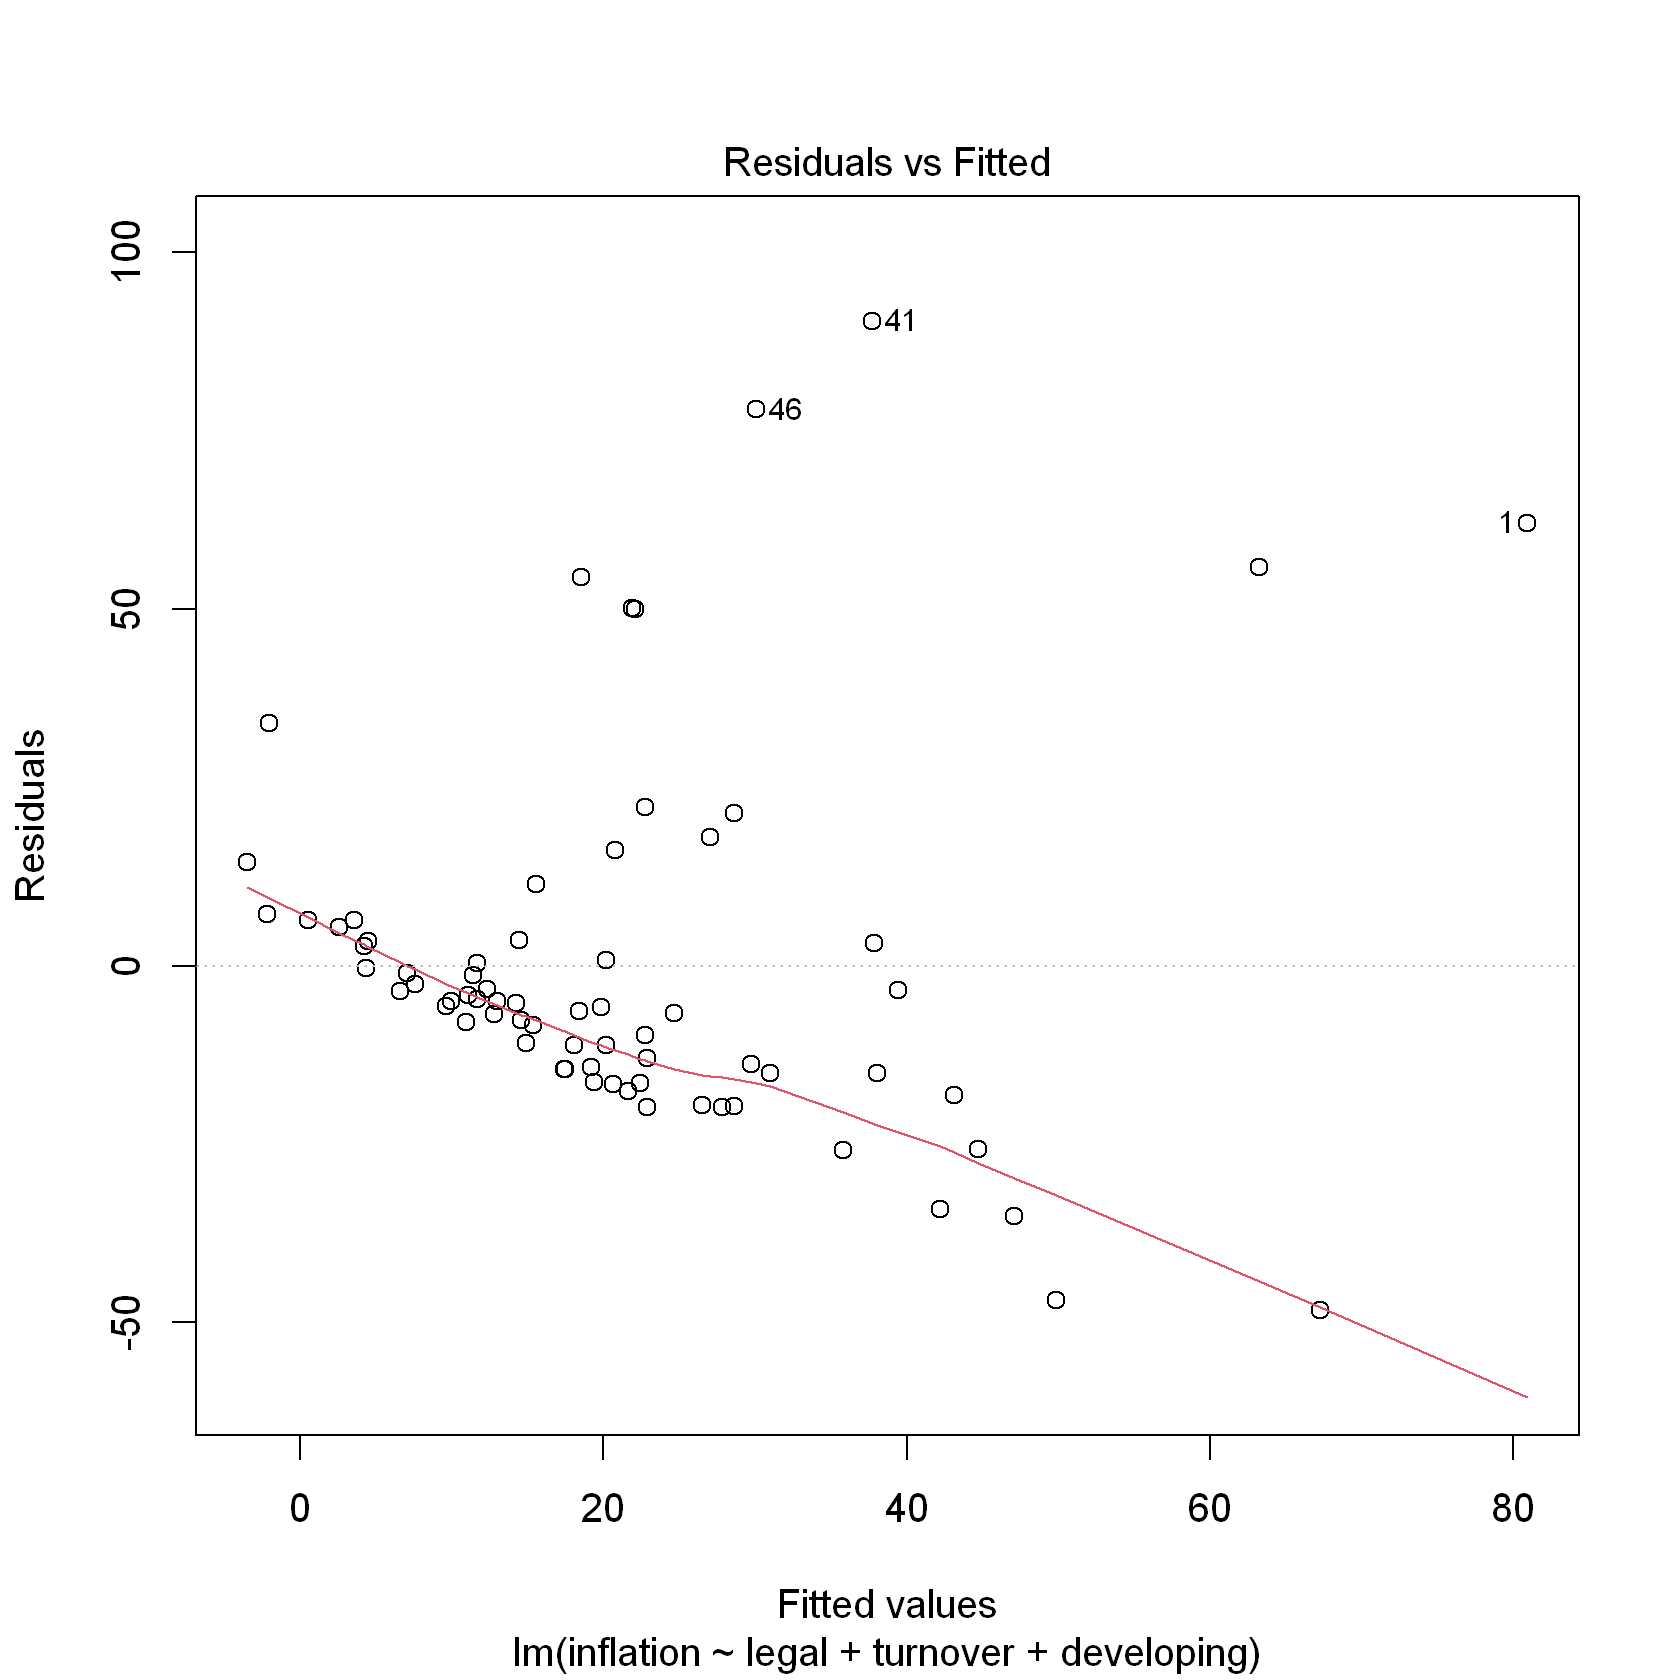

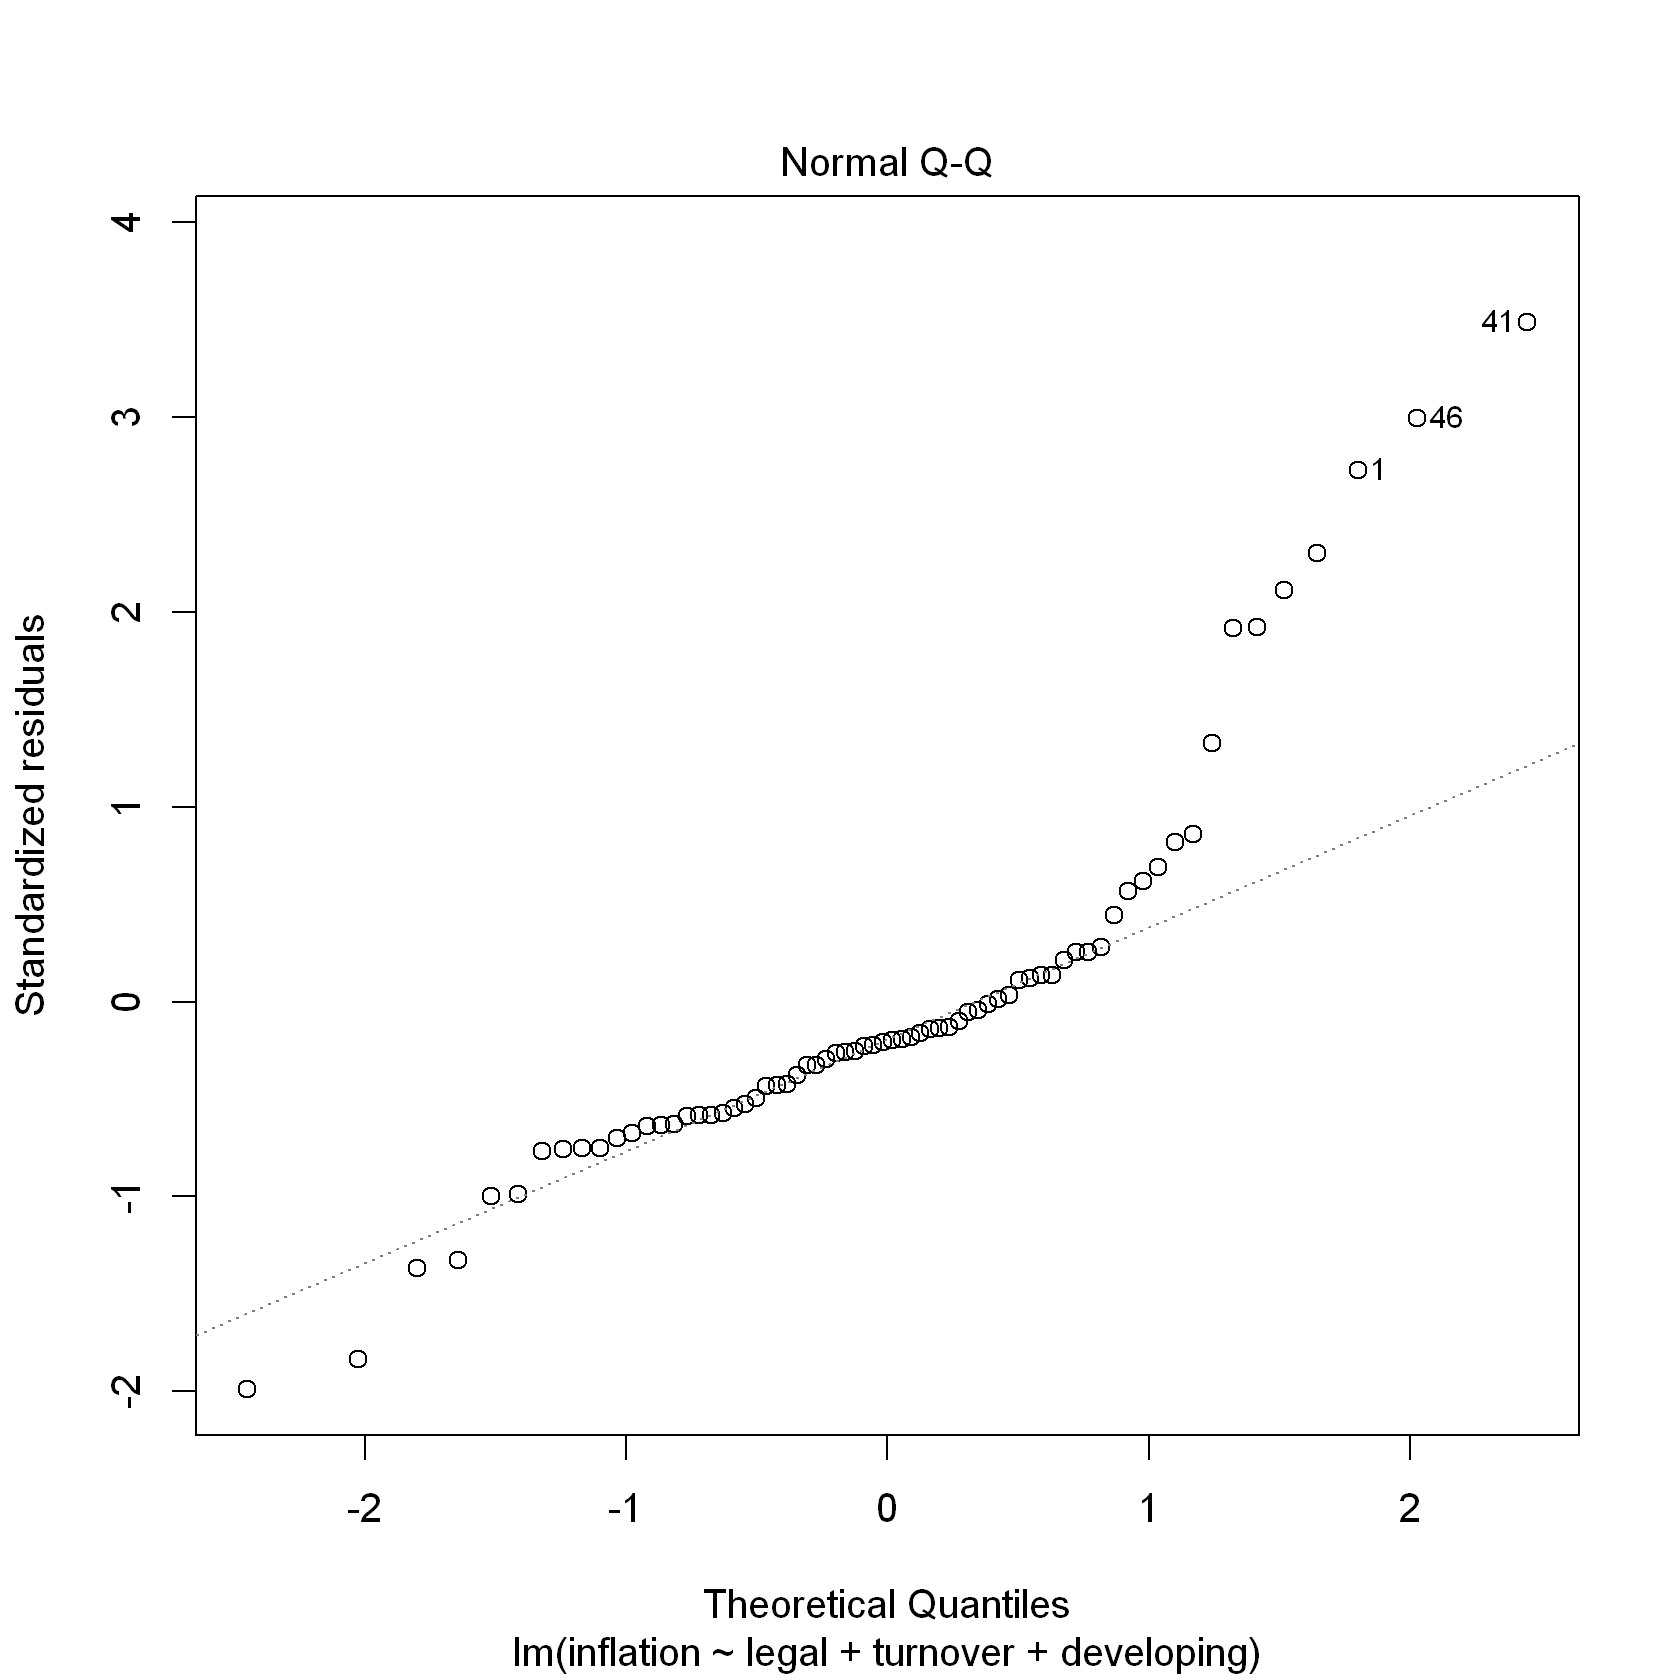

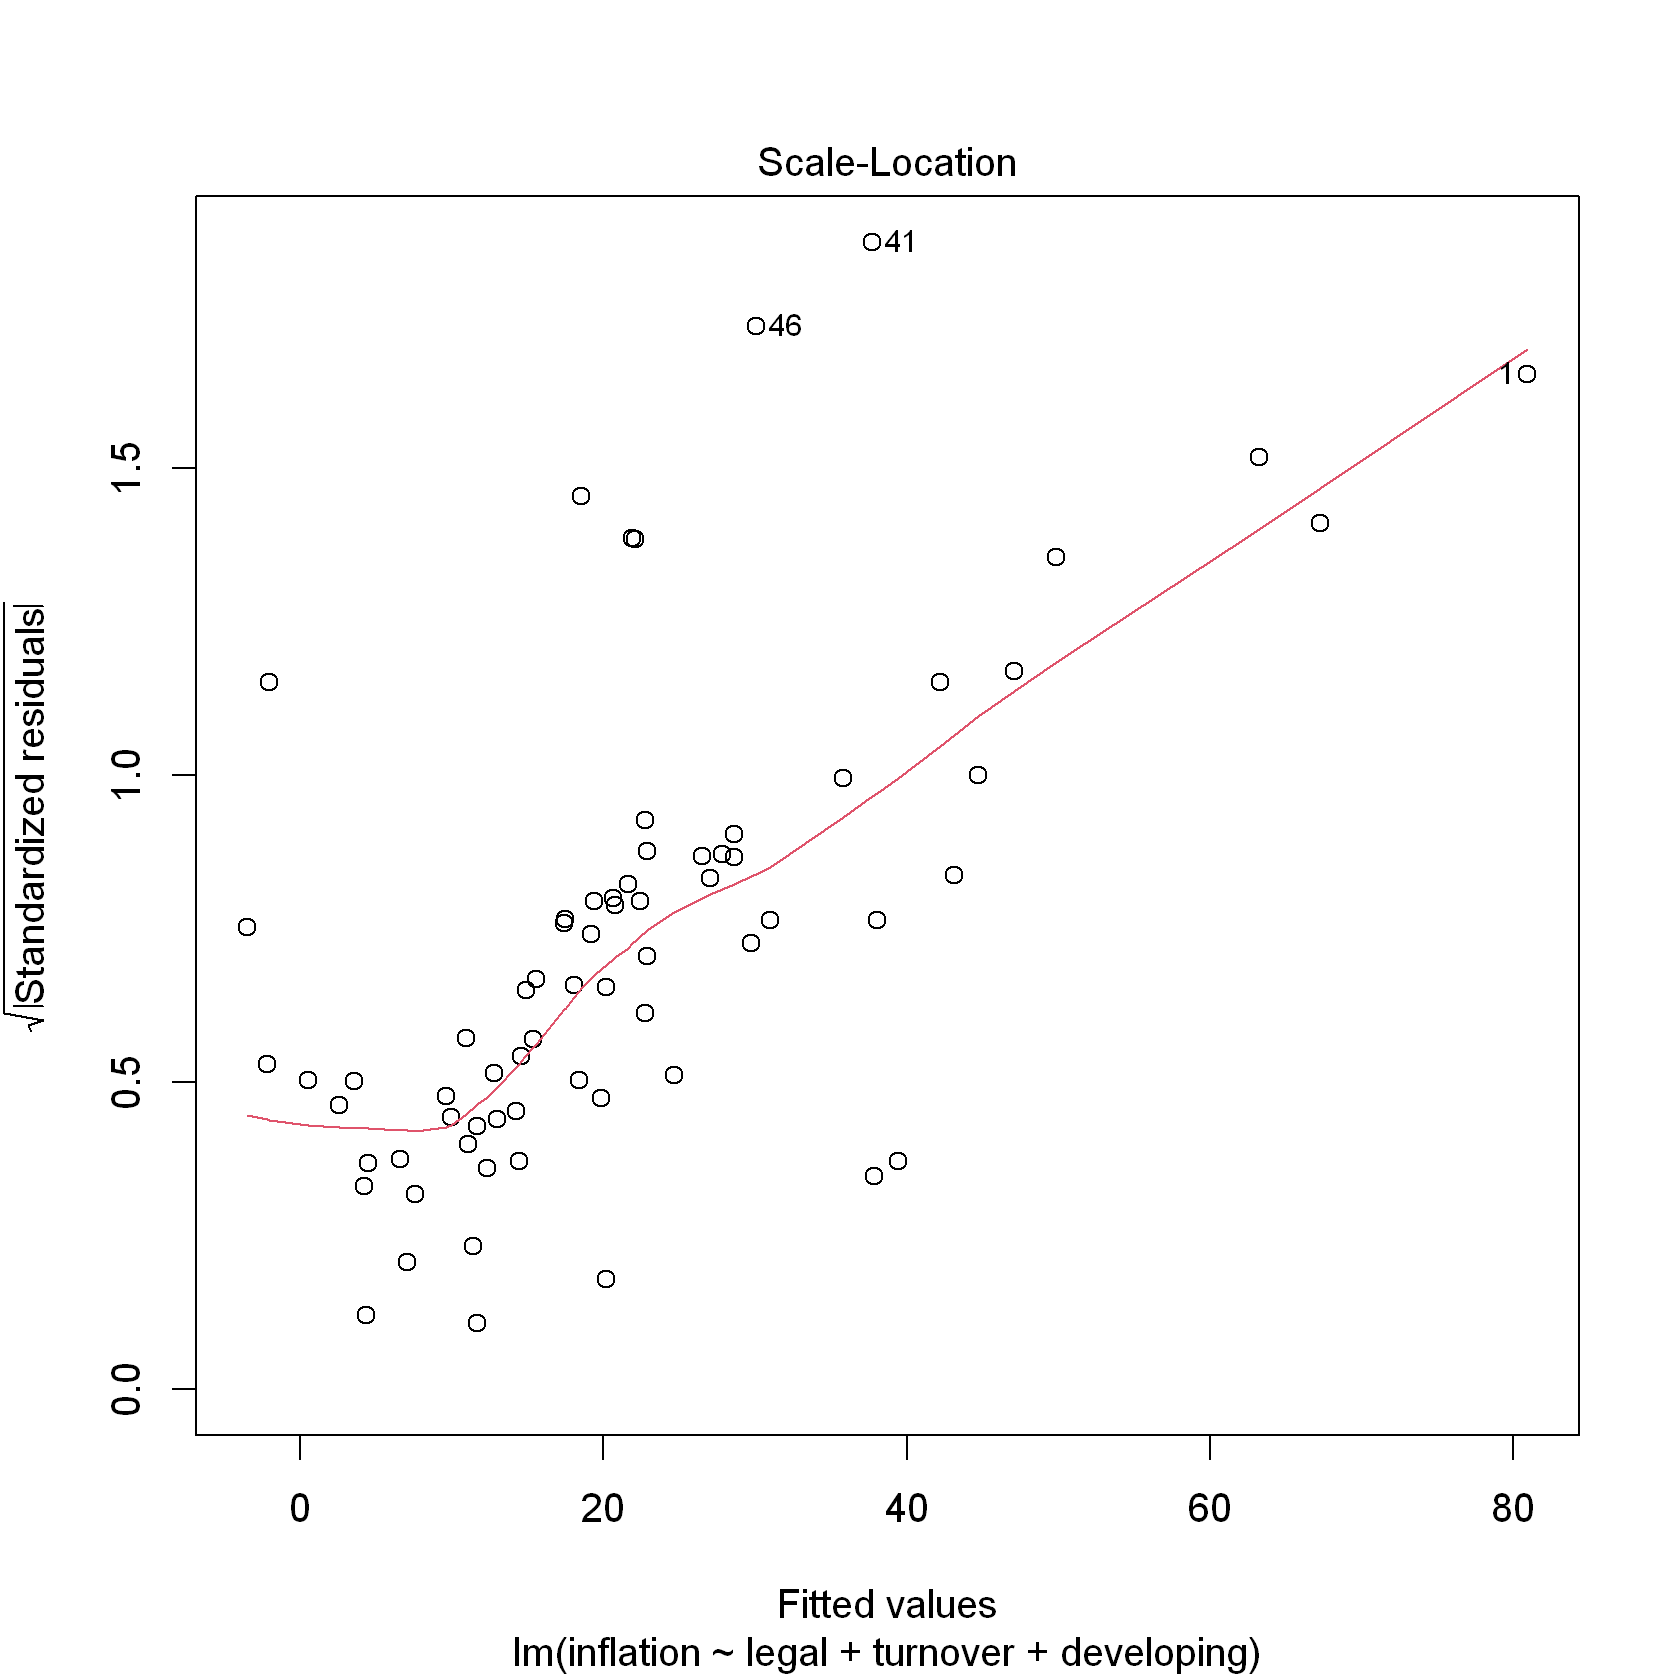

In [6]:
plot(fit, which=c(1, 2, 3))

### Part b

In [7]:
alpha <- 0.05
n = length(inflation)
p = 3
talpha <- qt(1 - alpha / 2, df=n-p-1)

ci.lower <- 16.014 - talpha * 26.230
ci.upper <- 16.014 + talpha * 26.230
sprintf('Lower: %.2f, Upper: %.2f', ci.lower, ci.upper)

[1] "Lower: -36.36, Upper: 68.38"

##### Based on the comments in part a I do not trust this confidence interval.

### Part c

[1] -0.3030303

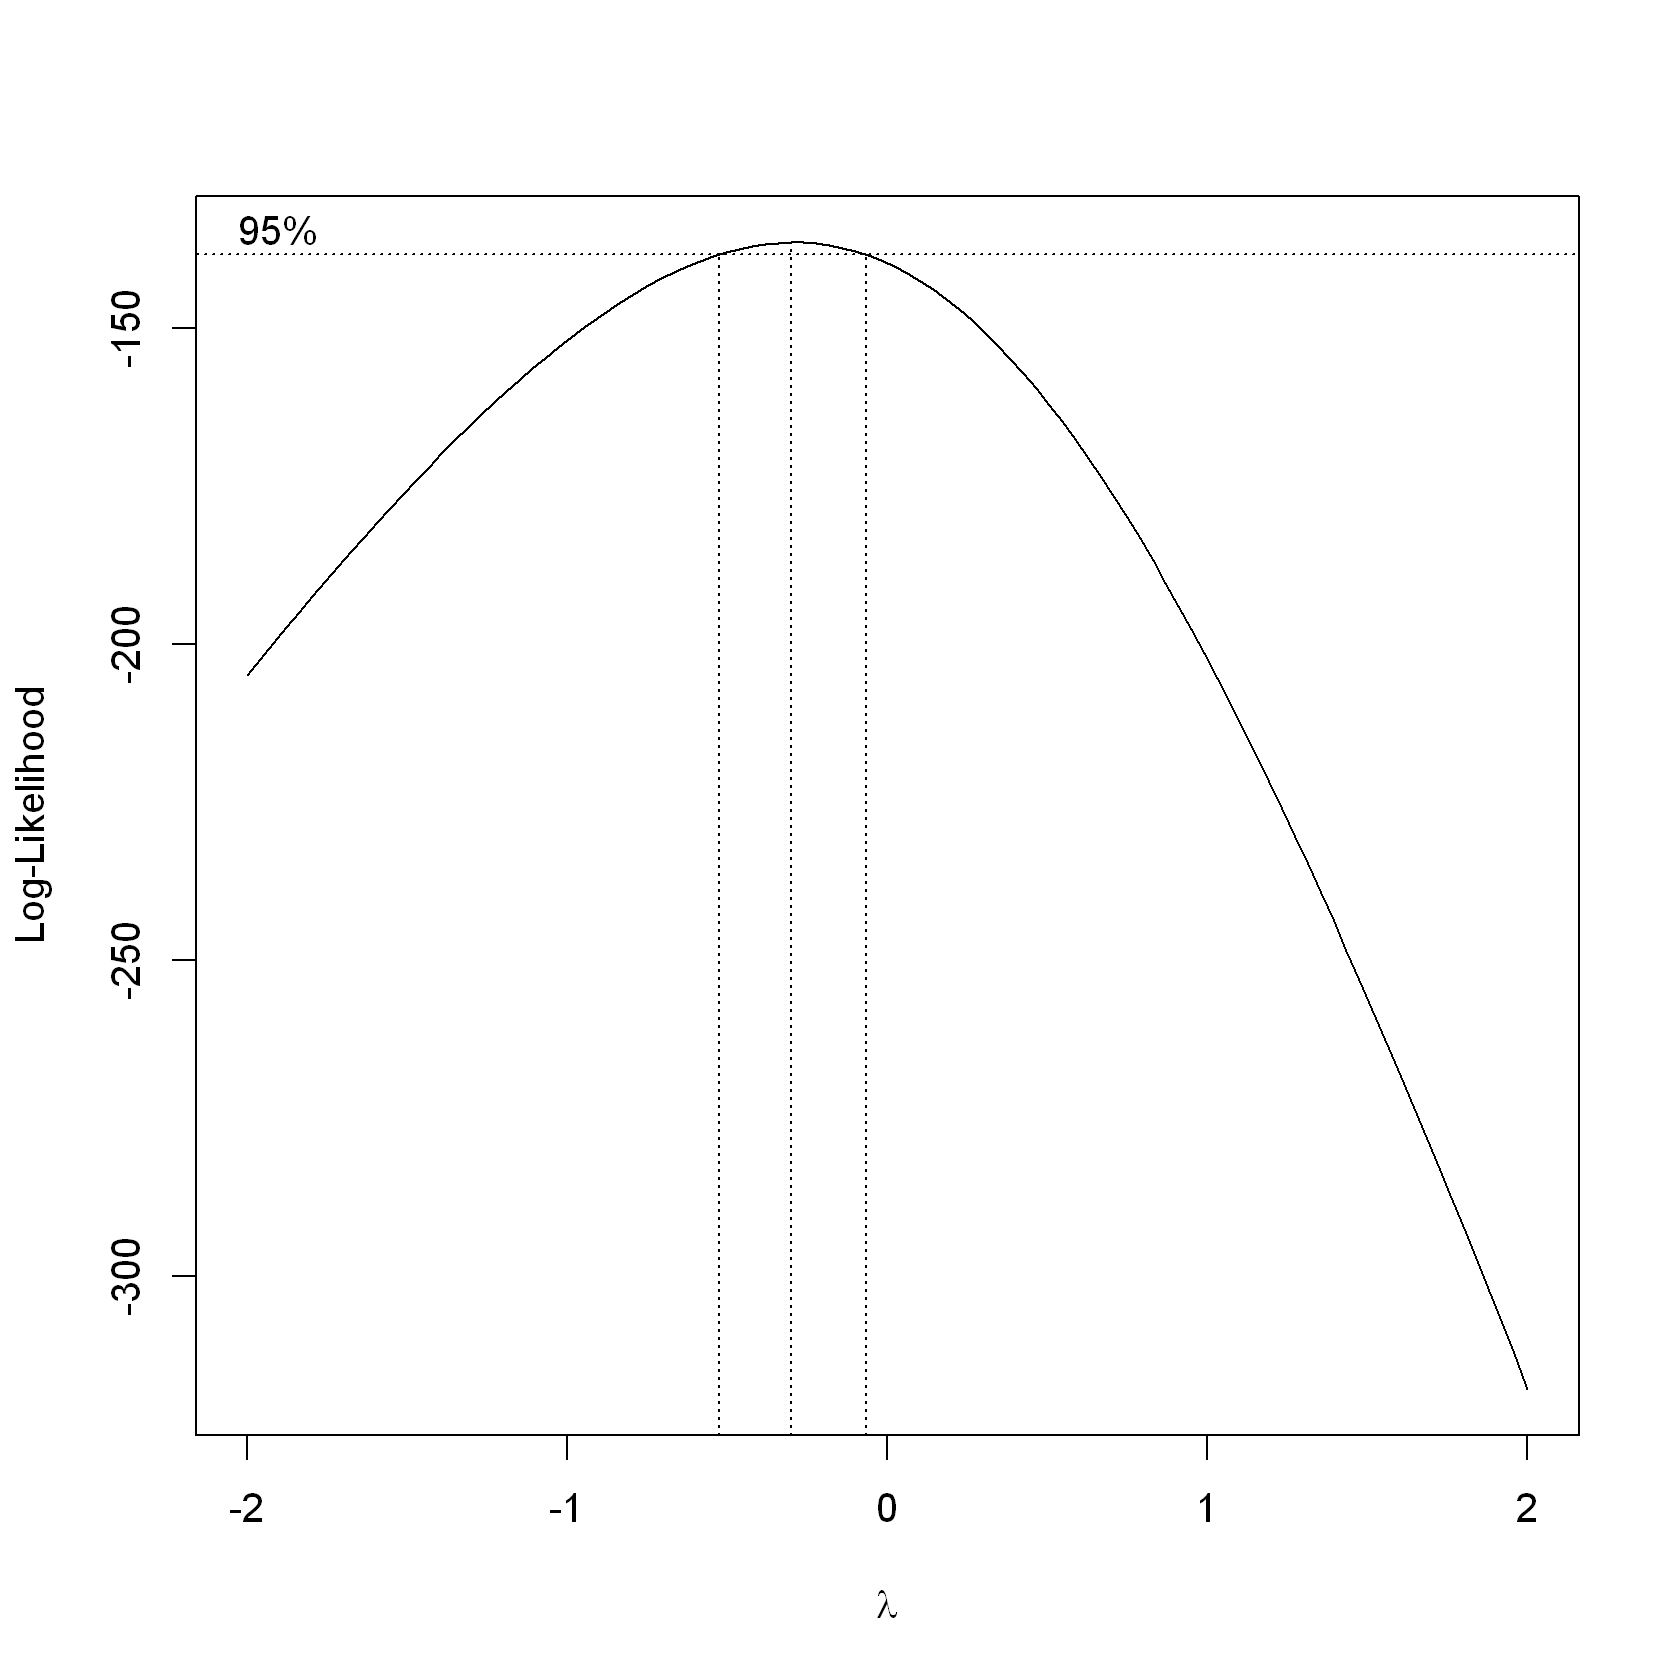

In [8]:
L.max <- boxcox(inflation ~ legal + turnover + developing, ylab="Log-Likelihood")
(alpha.bc <- L.max$x[which.max(L.max$y)])

In [9]:
inflation.bc = inflation^(alpha.bc)
fit.bc = lm(formula=inflation.bc~legal+turnover+developing)
summary(fit.bc)


Call:
lm(formula = inflation.bc ~ legal + turnover + developing)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.25279 -0.07890 -0.00521  0.07606  0.32483 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.51982    0.05057  10.279 2.48e-15 ***
legal        0.00186    0.12269   0.015   0.9879    
turnover    -0.21392    0.08456  -2.530   0.0138 *  
developingI  0.08220    0.03522   2.334   0.0227 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1236 on 66 degrees of freedom
Multiple R-squared:  0.2287,	Adjusted R-squared:  0.1937 
F-statistic: 6.525 on 3 and 66 DF,  p-value: 0.0006223


##### Distribution of residuals looks normal. Expectation is almost constant seems to have a slight parabolic relationship w/ fitted values. However, the variance is clearly decreasing. This model looks better than the first but there are still issues.

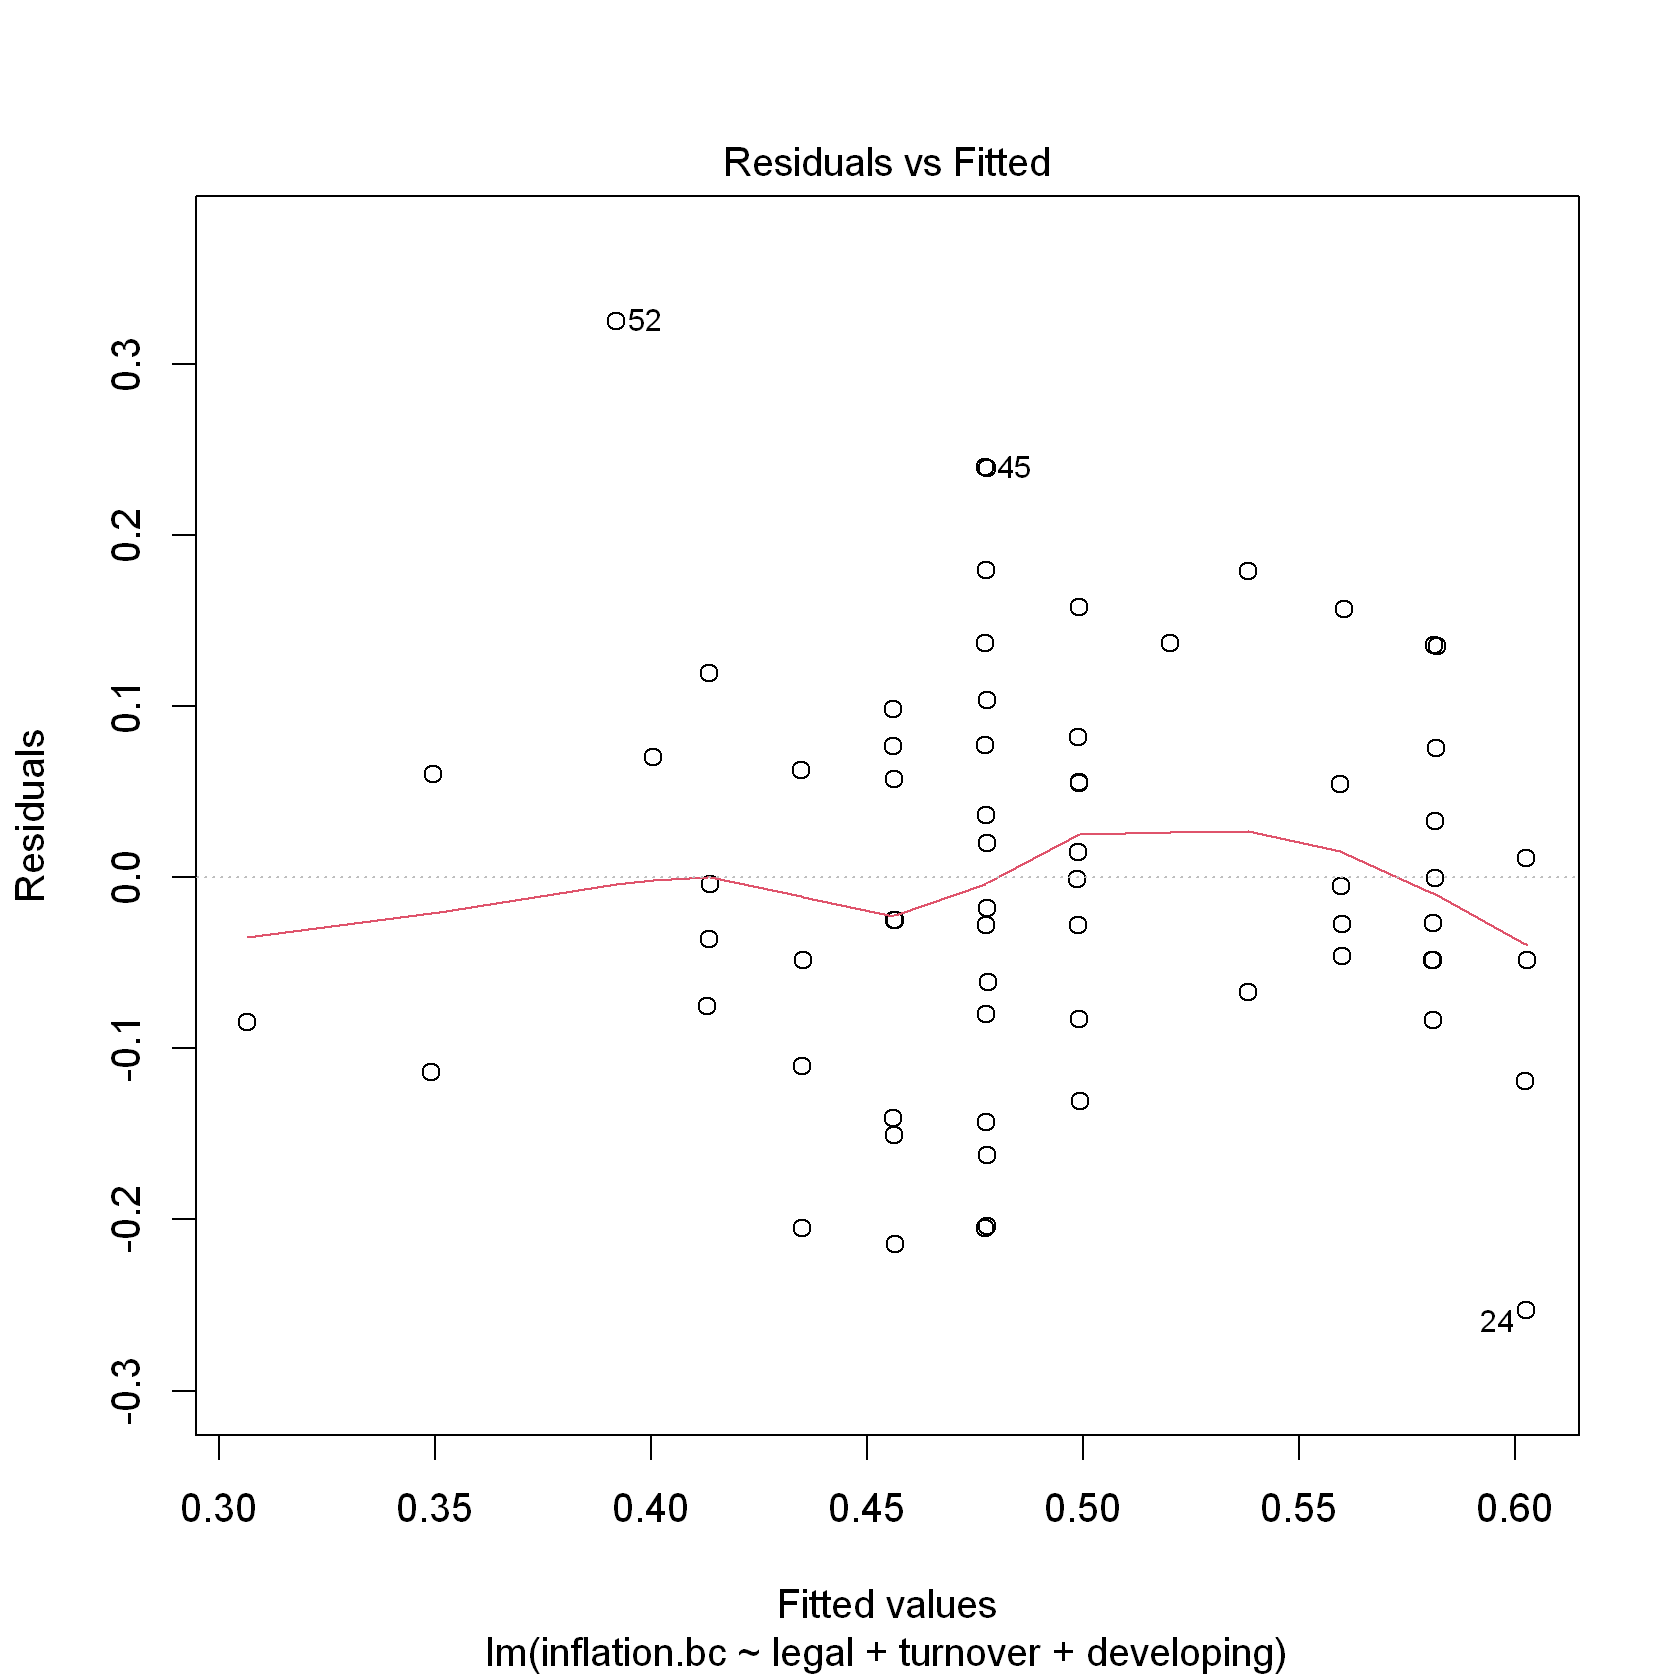

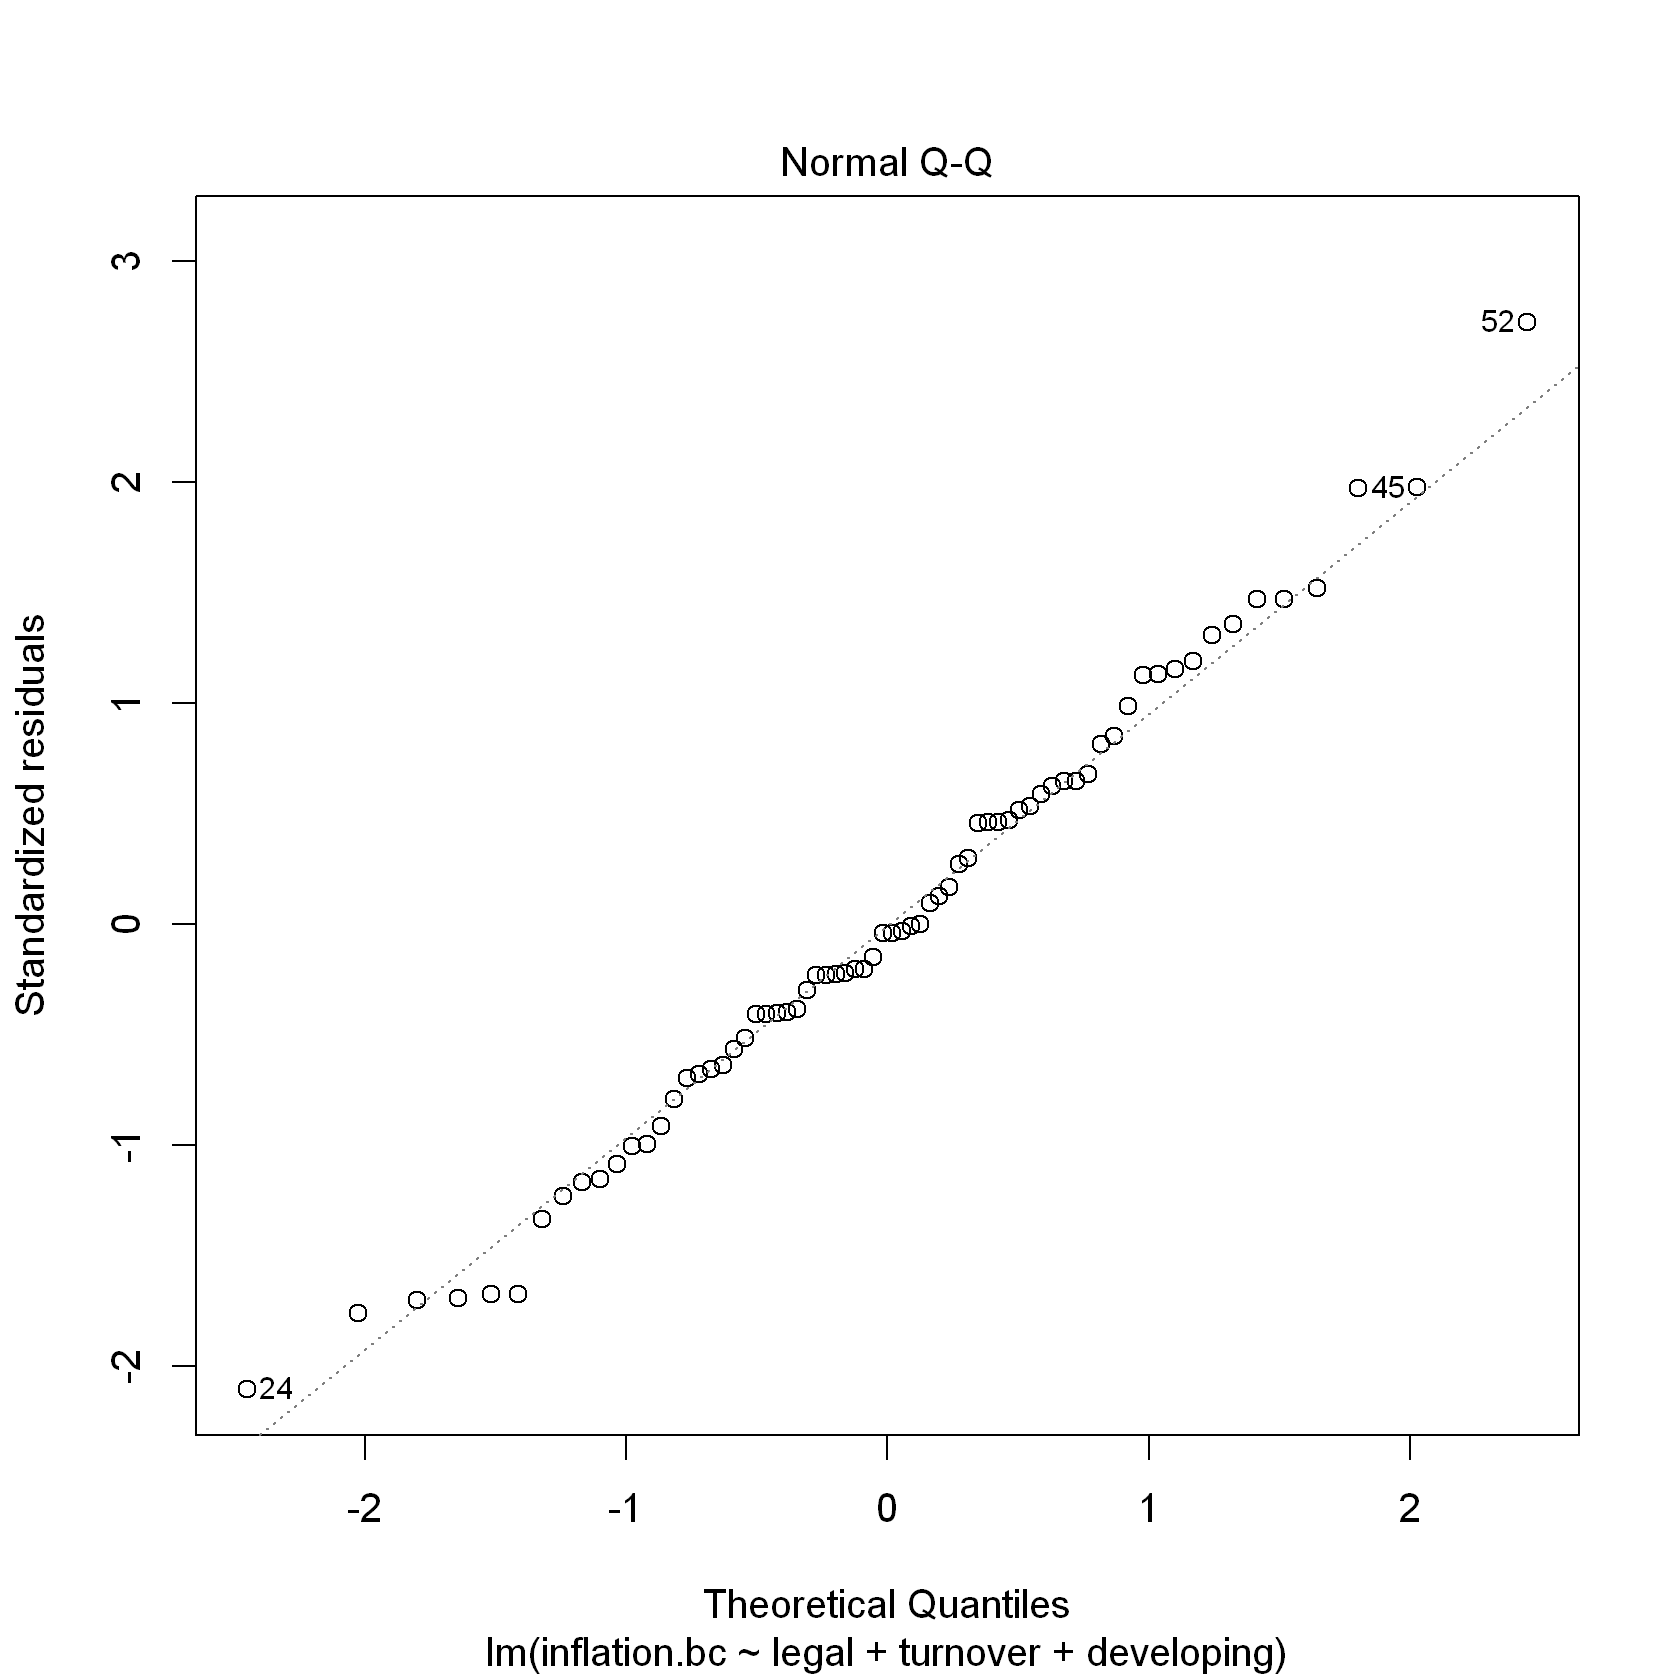

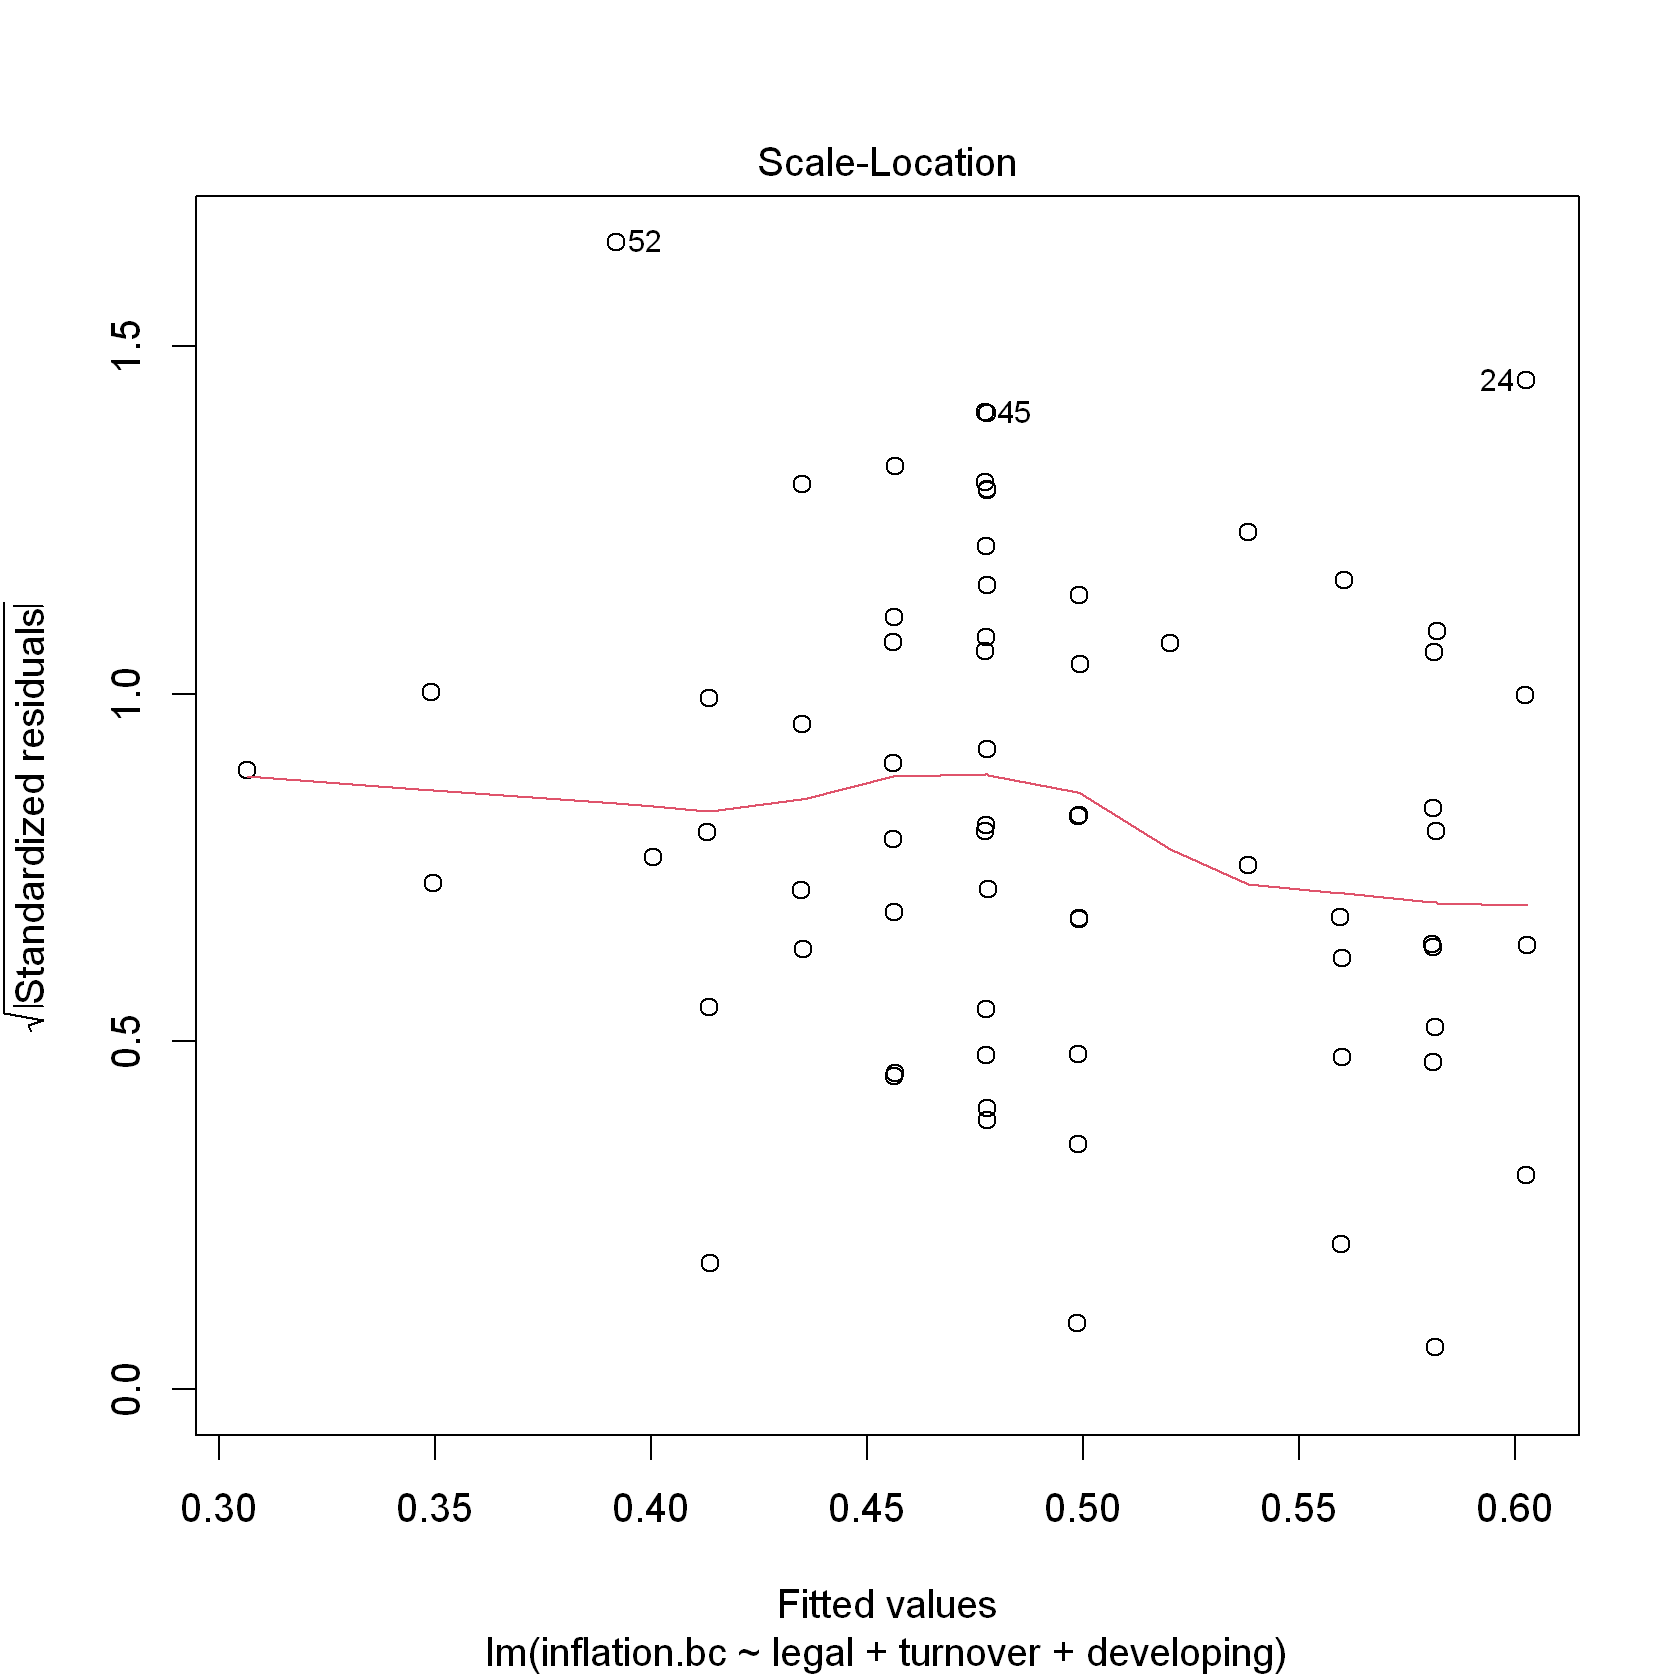

In [10]:
plot(fit.bc, which=c(1, 2, 3))

In [11]:
alpha <- 0.05
n = length(inflation)
p = 3
talpha <- qt(1 - alpha / 2, df=n-p-1)

ci.lower <- fit.bc$coefficients[2] - talpha * 0.12269
ci.upper <- fit.bc$coefficients[2] + talpha * 0.12269
sprintf('Lower: %.2f, Upper: %.2f', ci.lower, ci.upper)

[1] "Lower: -0.24, Upper: 0.25"

##### Because the the variance is still not constant I would not trust this confidence interval.

In [12]:
alpha <- 0.05
talpha <- qt(1 - alpha / 2, n - p - 1)

# construct the X matrix for prediction standard error calculation
# make sure to include columns of 1's for the intercept
X <- cbind(1, as.matrix(centralbank[, c('legal', 'turnover', 'developing_num')]))
# extract the X values for Singapore
sg.x <- as.numeric(matrix(c(1, centralbank[rownames(centralbank) == "Singapore", c('legal', 'turnover', 'developing_num')]), ncol=1))
# prediction is just dot product regression coeffs and X values
sg.pred = (coef(fit.bc) %*% sg.x)[1]^(1/alpha.bc)
# # calculate the variance of the residuals
resid.var = sum(resid(fit.bc)^2) / (n - p - 1)
# calculate standard error of prediction
sg.stderr = (sqrt(resid.var * t(sg.x) %*% solve(t(X) %*% X) %*% sg.x))[1]
# confidence interval calculation
sg.lb = sg.pred - talpha * sg.stderr
sg.ub = sg.pred + talpha * sg.stderr
cat(sprintf("The predicted Singapore inflation is %f\n", sg.pred))
cat(sprintf("The confidence interval for predicted Singapore inflation is [%f, %f]\n", sg.lb, sg.ub))

The predicted Singapore inflation is 21.985148
The confidence interval for predicted Singapore inflation is [21.921165, 22.049130]


##### Since the variance of the regression residuals is not constant I wouldn't trust this interval.

## Problem 2

In [13]:
load("forwardrates_data.Rdata")
attach(forwardrates)

### Part a

In [14]:
b_arrow = c(-0.2, 0.2, 0.2, 0.7, 4.7, 24.7)

In [15]:
head(forwardrates)

,rate,maturity
,<dbl>,<dbl>
1,0.05138920,0.3699
2,0.05008213,0.6219
3,0.04970744,0.8740
4,0.05031624,1.1260
5,0.05661163,1.3699
6,0.04904562,1.6219


In [16]:
fwd.fit = nls(rate ~ b0  + b1*exp(-maturity/b4) + (b2/b4)*maturity*exp(-maturity/b4) + (b3/b5) * maturity * exp(-maturity/b5), start=list(b0=b_arrow[1], b1=b_arrow[2], b2=b_arrow[3], b3=b_arrow[4], b4=b_arrow[5], b5=b_arrow[6]))
fwd.fit.sum = summary(fwd.fit)
coefs = fwd.fit.sum$coef[, 1]

In [17]:
fwd.est = coefs[1] + coefs[2]*exp(-maturity/coefs[5]) + (coefs[3]/coefs[5])*maturity*exp(-maturity/coefs[5]) + (coefs[4]/coefs[6]) * maturity * exp(-maturity/coefs[6])

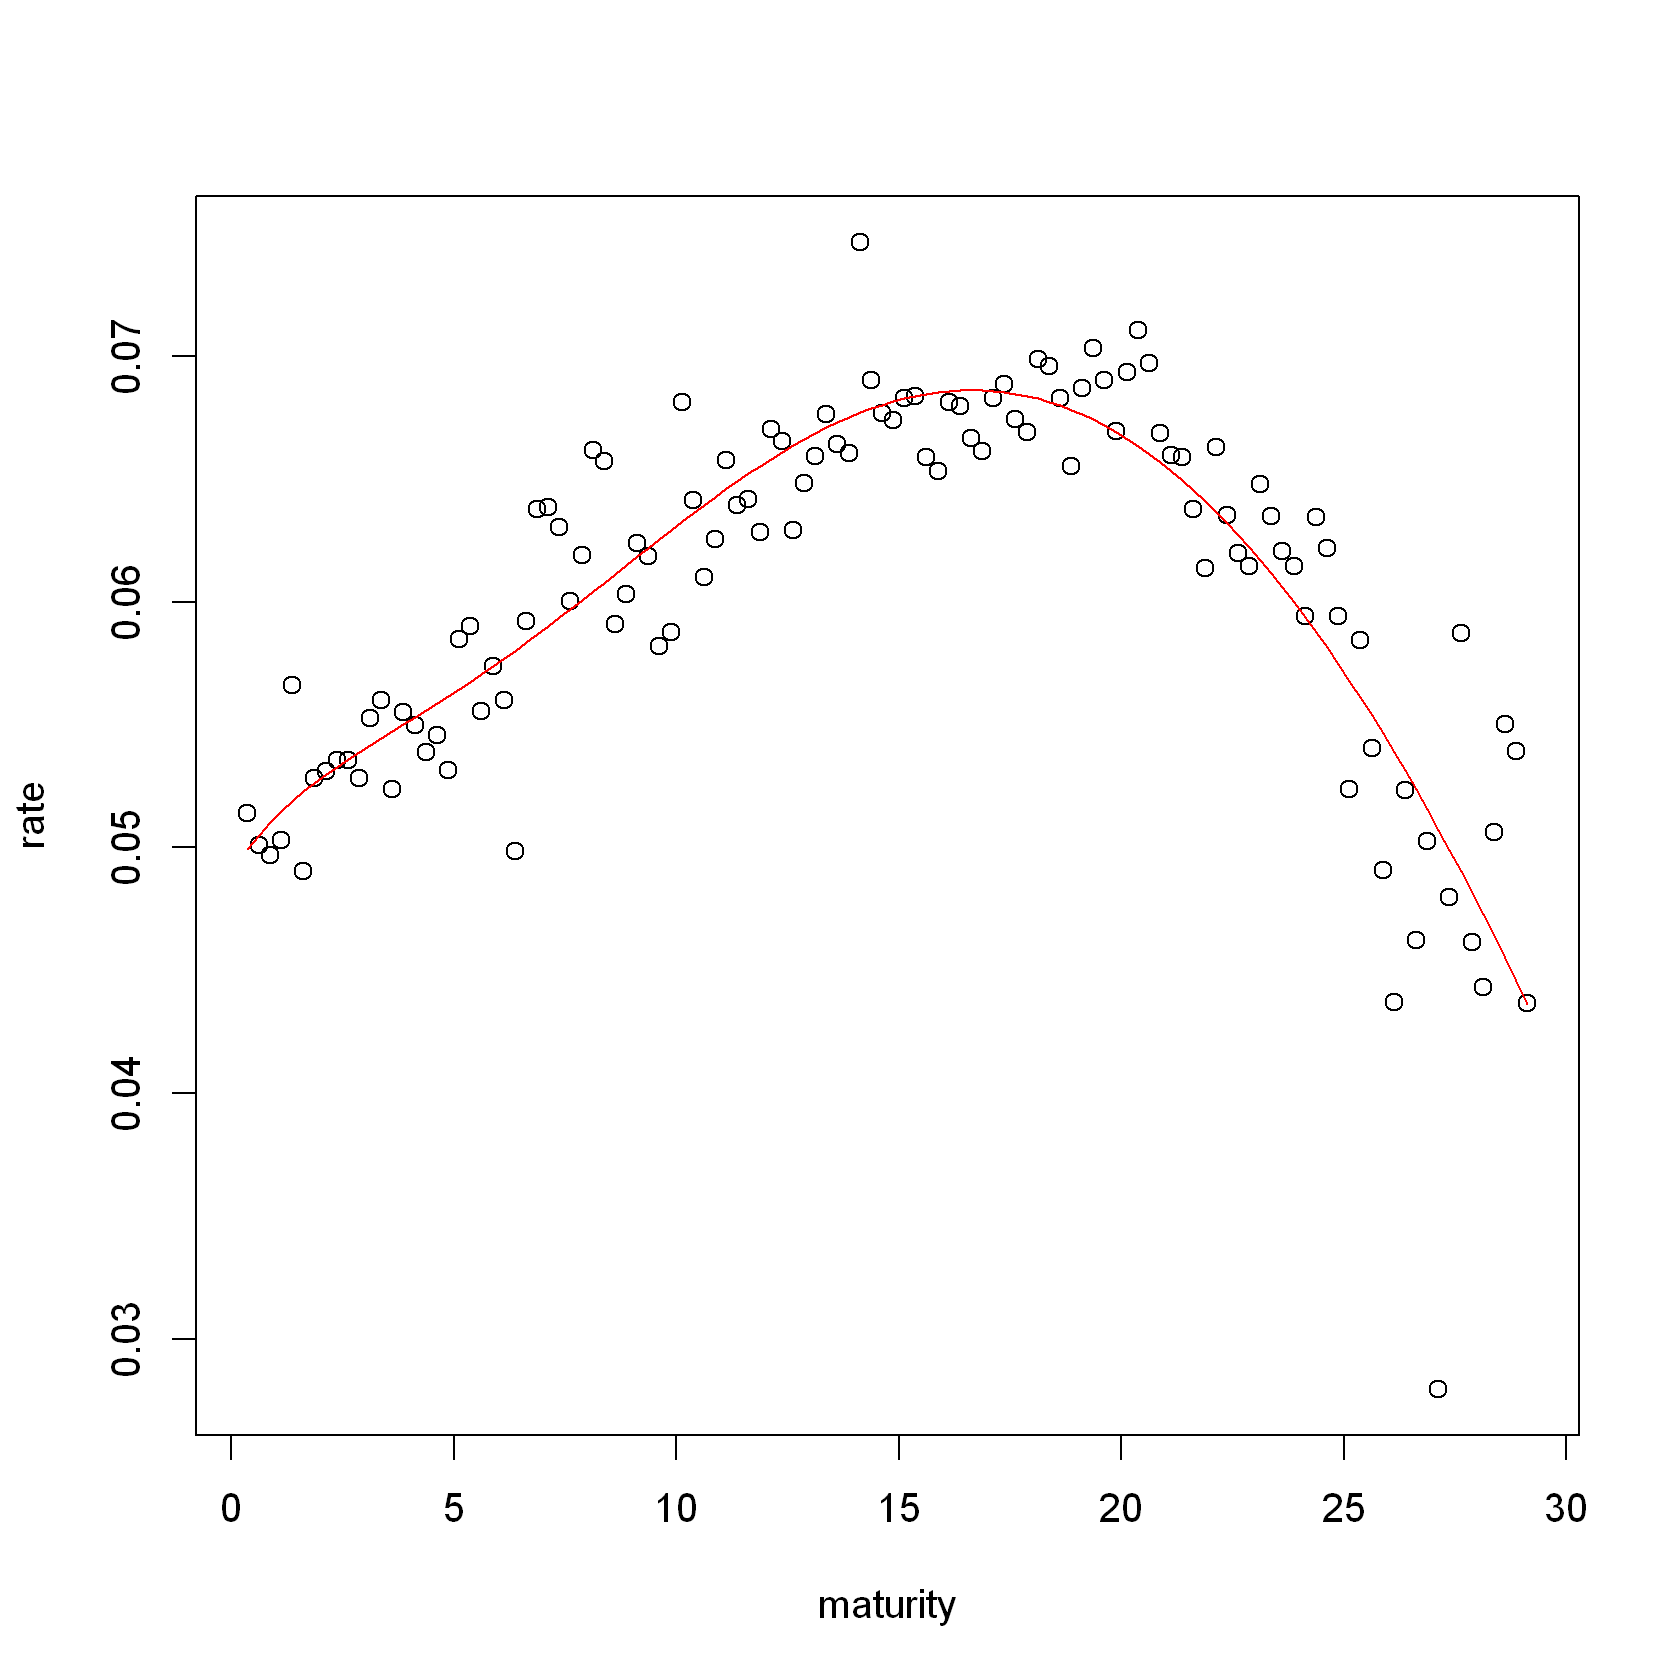

In [18]:
plot(maturity, rate)
lines(maturity, fwd.est, col='red')

### Part b

$$
    W_i = Y_i - f(X_i; \hat{\beta}) + \nabla_{\beta}f(X_i;\hat{\beta})^T\hat{\beta}
$$
$$
    Y_i = f(X_i; \overrightarrow{\beta}) + \epsilon_i
$$
$$
    f(X_i; \overrightarrow{\beta}) \approx f(X_i;\hat{\beta}) + \nabla_{\beta}f(X_i;\hat{\beta})^T(\overrightarrow{\beta}-\hat{\beta})
$$
$$
    W_i = f(X_i; \overrightarrow{\beta}) - f(X_i; \hat{\beta}) + \nabla_{\beta}f(X_i;\hat{\beta})^T\hat{\beta} + \epsilon_i 
$$
$$
    W_i \approx f(X_i;\hat{\beta}) + \nabla_{\beta}f(X_i;\hat{\beta})^T\overrightarrow{\beta} - \nabla_{\beta}f(X_i;\hat{\beta})^T\hat{\beta}  - f(X_i; \hat{\beta}) + \nabla_{\beta}f(X_i;\hat{\beta})^T\hat{\beta} + \epsilon_i 
$$
$$
    W_i \approx \nabla_{\beta}f(X_i;\hat{\beta})^T\overrightarrow{\beta} + \epsilon_i 
$$
$$
    W_i \approx V_i^T\overrightarrow{\beta} + \epsilon_i 
$$

### Part c

In [19]:
f_gradient <- function(b, t) {
    val = c(
        1, 
        exp(-t/b[5]), 
        (t/b[5]) * exp(-t/b[5]), 
        (t/b[6])*exp(-t/b[6]), 
        (b[3]*t^2 - b[5]*b[3]*t + b[5]*b[2]*t)/(b[5]^3) * exp(-t/b[5]), 
        (b[4]*t^2-b[6]*b[4]*t)/(b[6]^3) * exp(-t/b[6])
    )
    return(val)
}

In [20]:
V_i = matrix(nrow=length(maturity), ncol=6)
for (k in 1:length(maturity)) {
    V_i[k, ] = f_gradient(as.numeric(coefs), maturity[k])
}

In [21]:
W_i = V_i %*% coefs + fwd.fit.sum$residuals

In [22]:
fwd.fit.grad = lm(W_i ~  V_i[, 2] + V_i[, 3] + V_i[, 4] + V_i[, 5] + V_i[, 6])

In [23]:
summary(fwd.fit.grad)


Call:
lm(formula = W_i ~ V_i[, 2] + V_i[, 3] + V_i[, 4] + V_i[, 5] + 
    V_i[, 6])

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0227528 -0.0014765  0.0000067  0.0014877  0.0096563 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.27895    0.28778  -0.969 0.334507    
V_i[, 2]     0.32796    0.28957   1.133 0.259857    
V_i[, 3]     0.13203    0.07482   1.765 0.080389 .  
V_i[, 4]     0.89299    0.69708   1.281 0.202874    
V_i[, 5]     5.37988    2.77269   1.940 0.054901 .  
V_i[, 6]    22.78744    6.36715   3.579 0.000515 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.003848 on 110 degrees of freedom
Multiple R-squared:  0.9877,	Adjusted R-squared:  0.9871 
F-statistic:  1764 on 5 and 110 DF,  p-value: < 2.2e-16


In [24]:
fwd.fit.sum


Formula: rate ~ b0 + b1 * exp(-maturity/b4) + (b2/b4) * maturity * exp(-maturity/b4) + 
    (b3/b5) * maturity * exp(-maturity/b5)

Parameters:
   Estimate Std. Error t value Pr(>|t|)    
b0 -0.27898    0.28778  -0.969 0.334467    
b1  0.32798    0.28957   1.133 0.259823    
b2  0.13204    0.07482   1.765 0.080377 .  
b3  0.89304    0.69708   1.281 0.202845    
b4  5.38011    2.77269   1.940 0.054891 .  
b5 22.78796    6.36715   3.579 0.000515 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.003848 on 110 degrees of freedom

Number of iterations to convergence: 18 
Achieved convergence tolerance: 7.648e-06


## Problem 3

### Part a

In [25]:
mu.hat <- function(x.out, x, y, b) {
    y.out <- numeric(length(x.out))
    for (k in 1:length(x.out)) {
        w <- dnorm(x, mean=x.out[k], sd=b)
        fit <- lm(formula = y ~ I(x - x.out[k]) + I((x - x.out[k])^2), weights=w)
        y.out[k] <- fit$coefficients[1]
    }
    return(y.out)
}

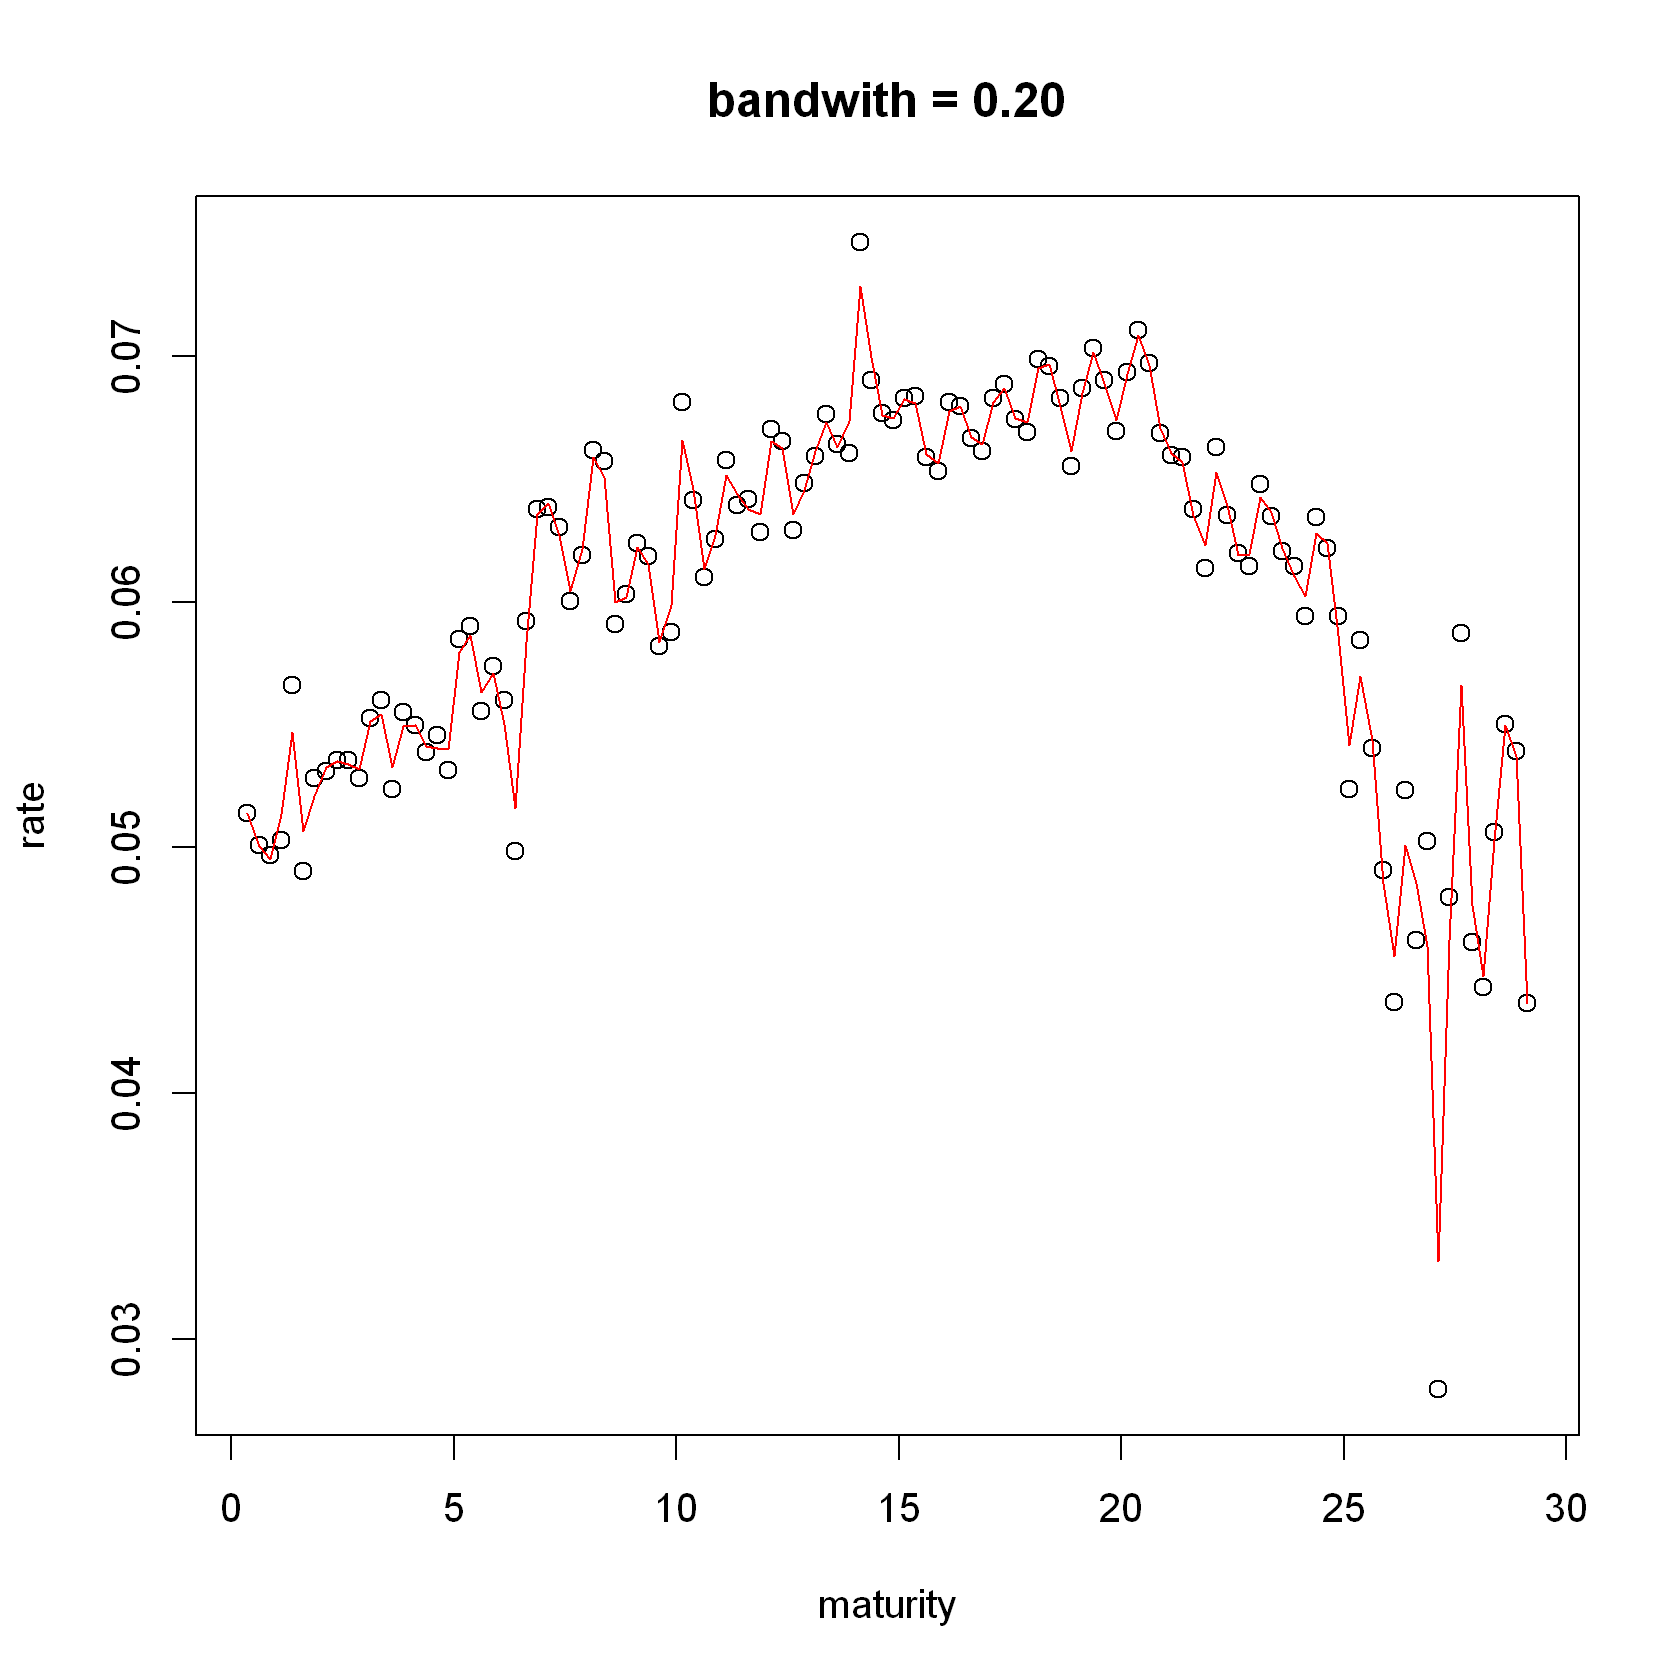

In [26]:
b = 0.2
plot(maturity, rate, main=sprintf('bandwith = %.2f', b))
lines(maturity, mu.hat(maturity, maturity, rate, b), col='red')

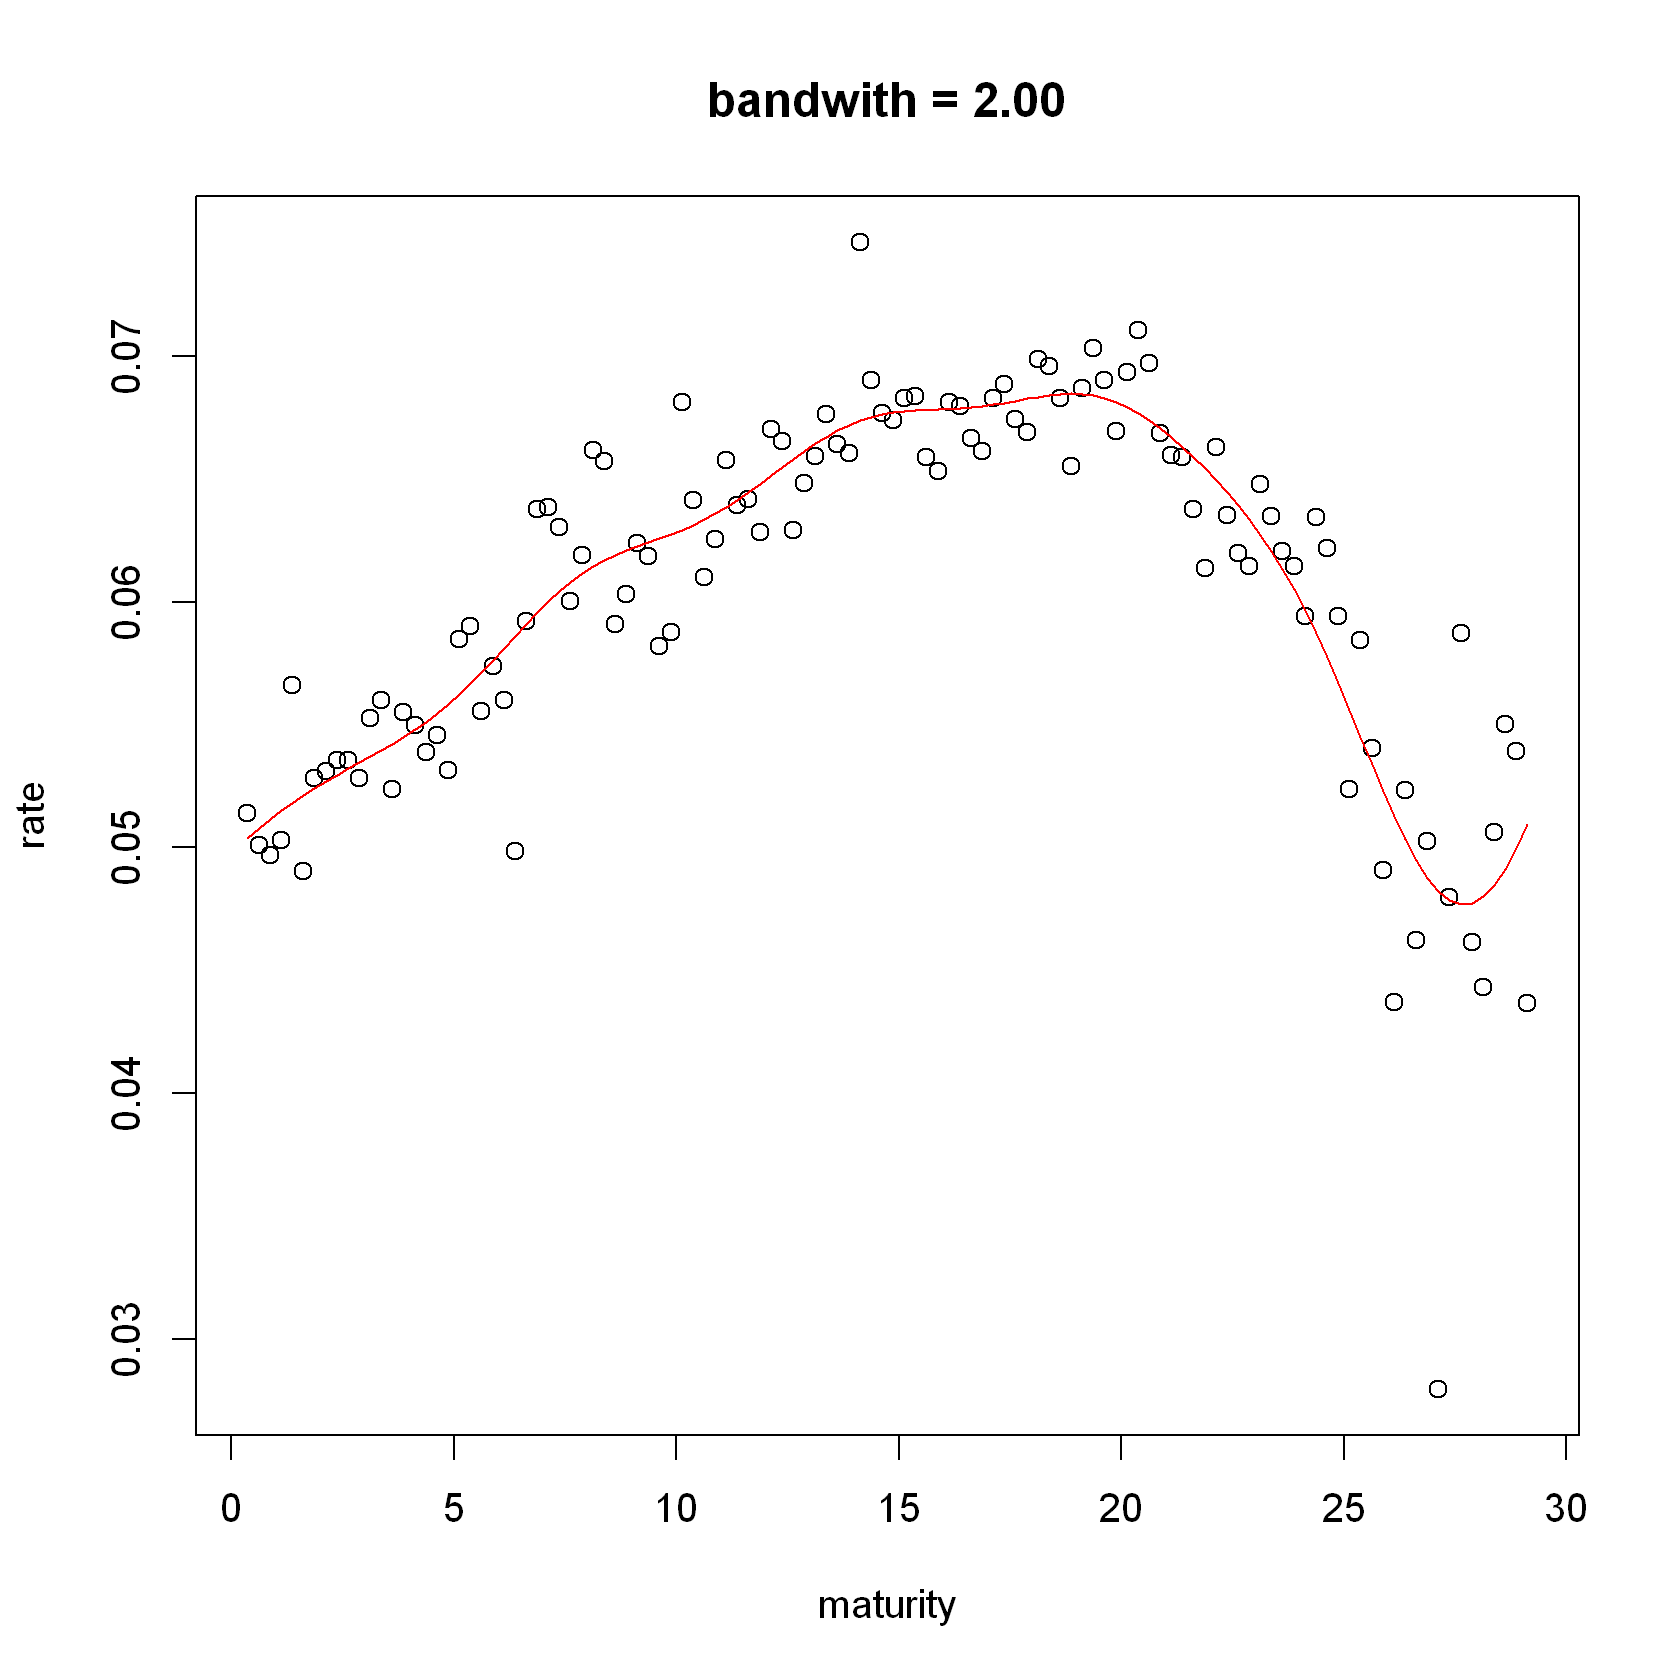

In [27]:
b = 2
plot(maturity, rate, main=sprintf('bandwith = %.2f', b))
lines(maturity, mu.hat(maturity, maturity, rate, b), col='red')

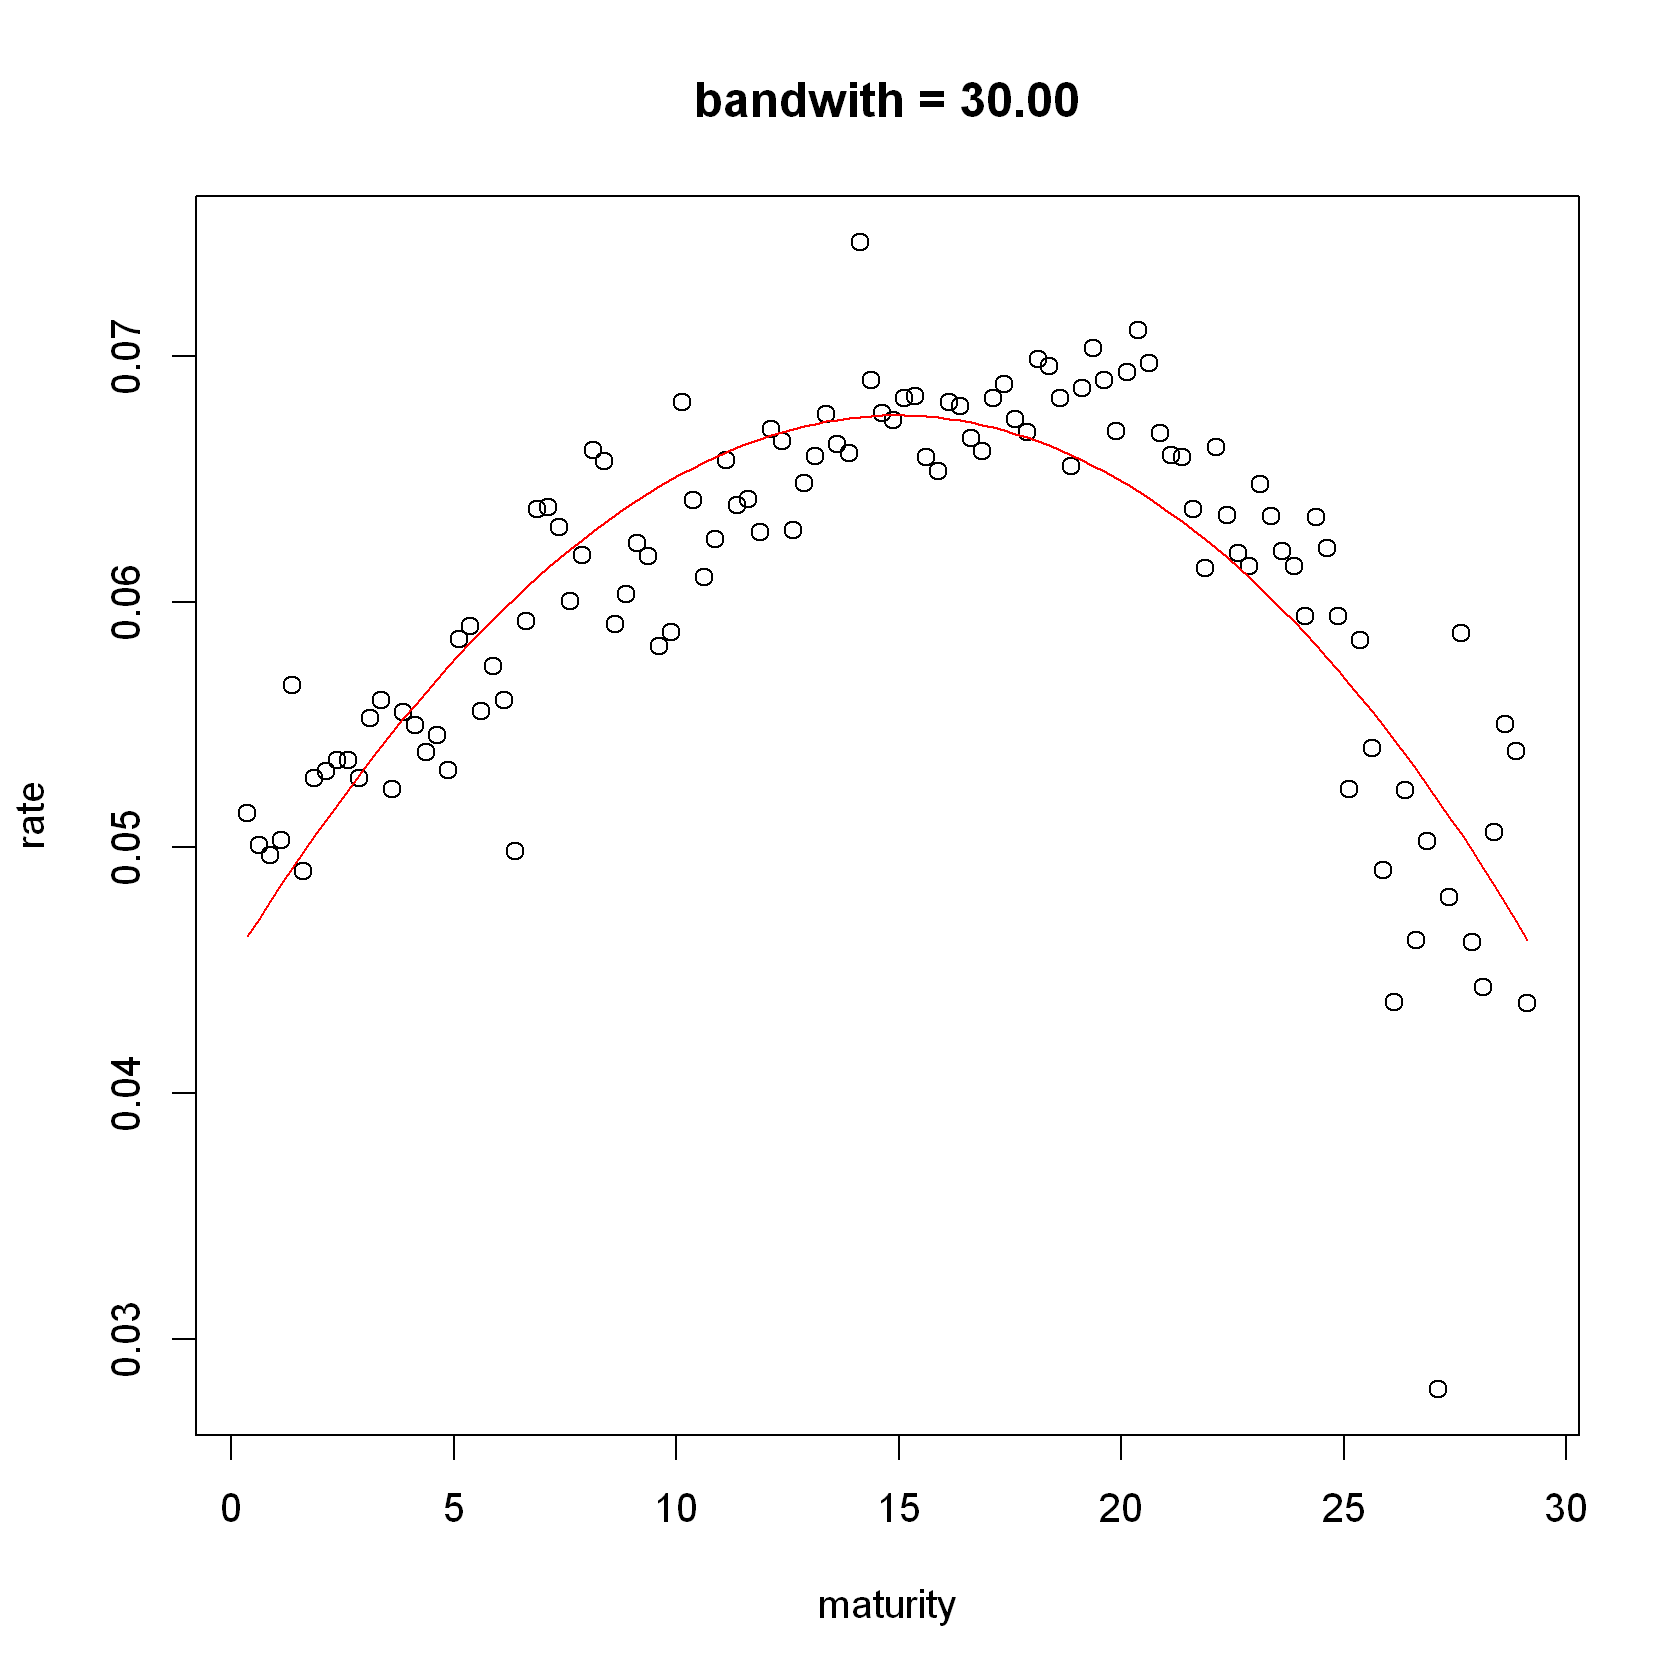

In [28]:
b = 30
plot(maturity, rate, main=sprintf('bandwith = %.2f', b))
lines(maturity, mu.hat(maturity, maturity, rate, b), col='red')

In [29]:
(h <- dpill(maturity, rate))

[1] 0.7938594

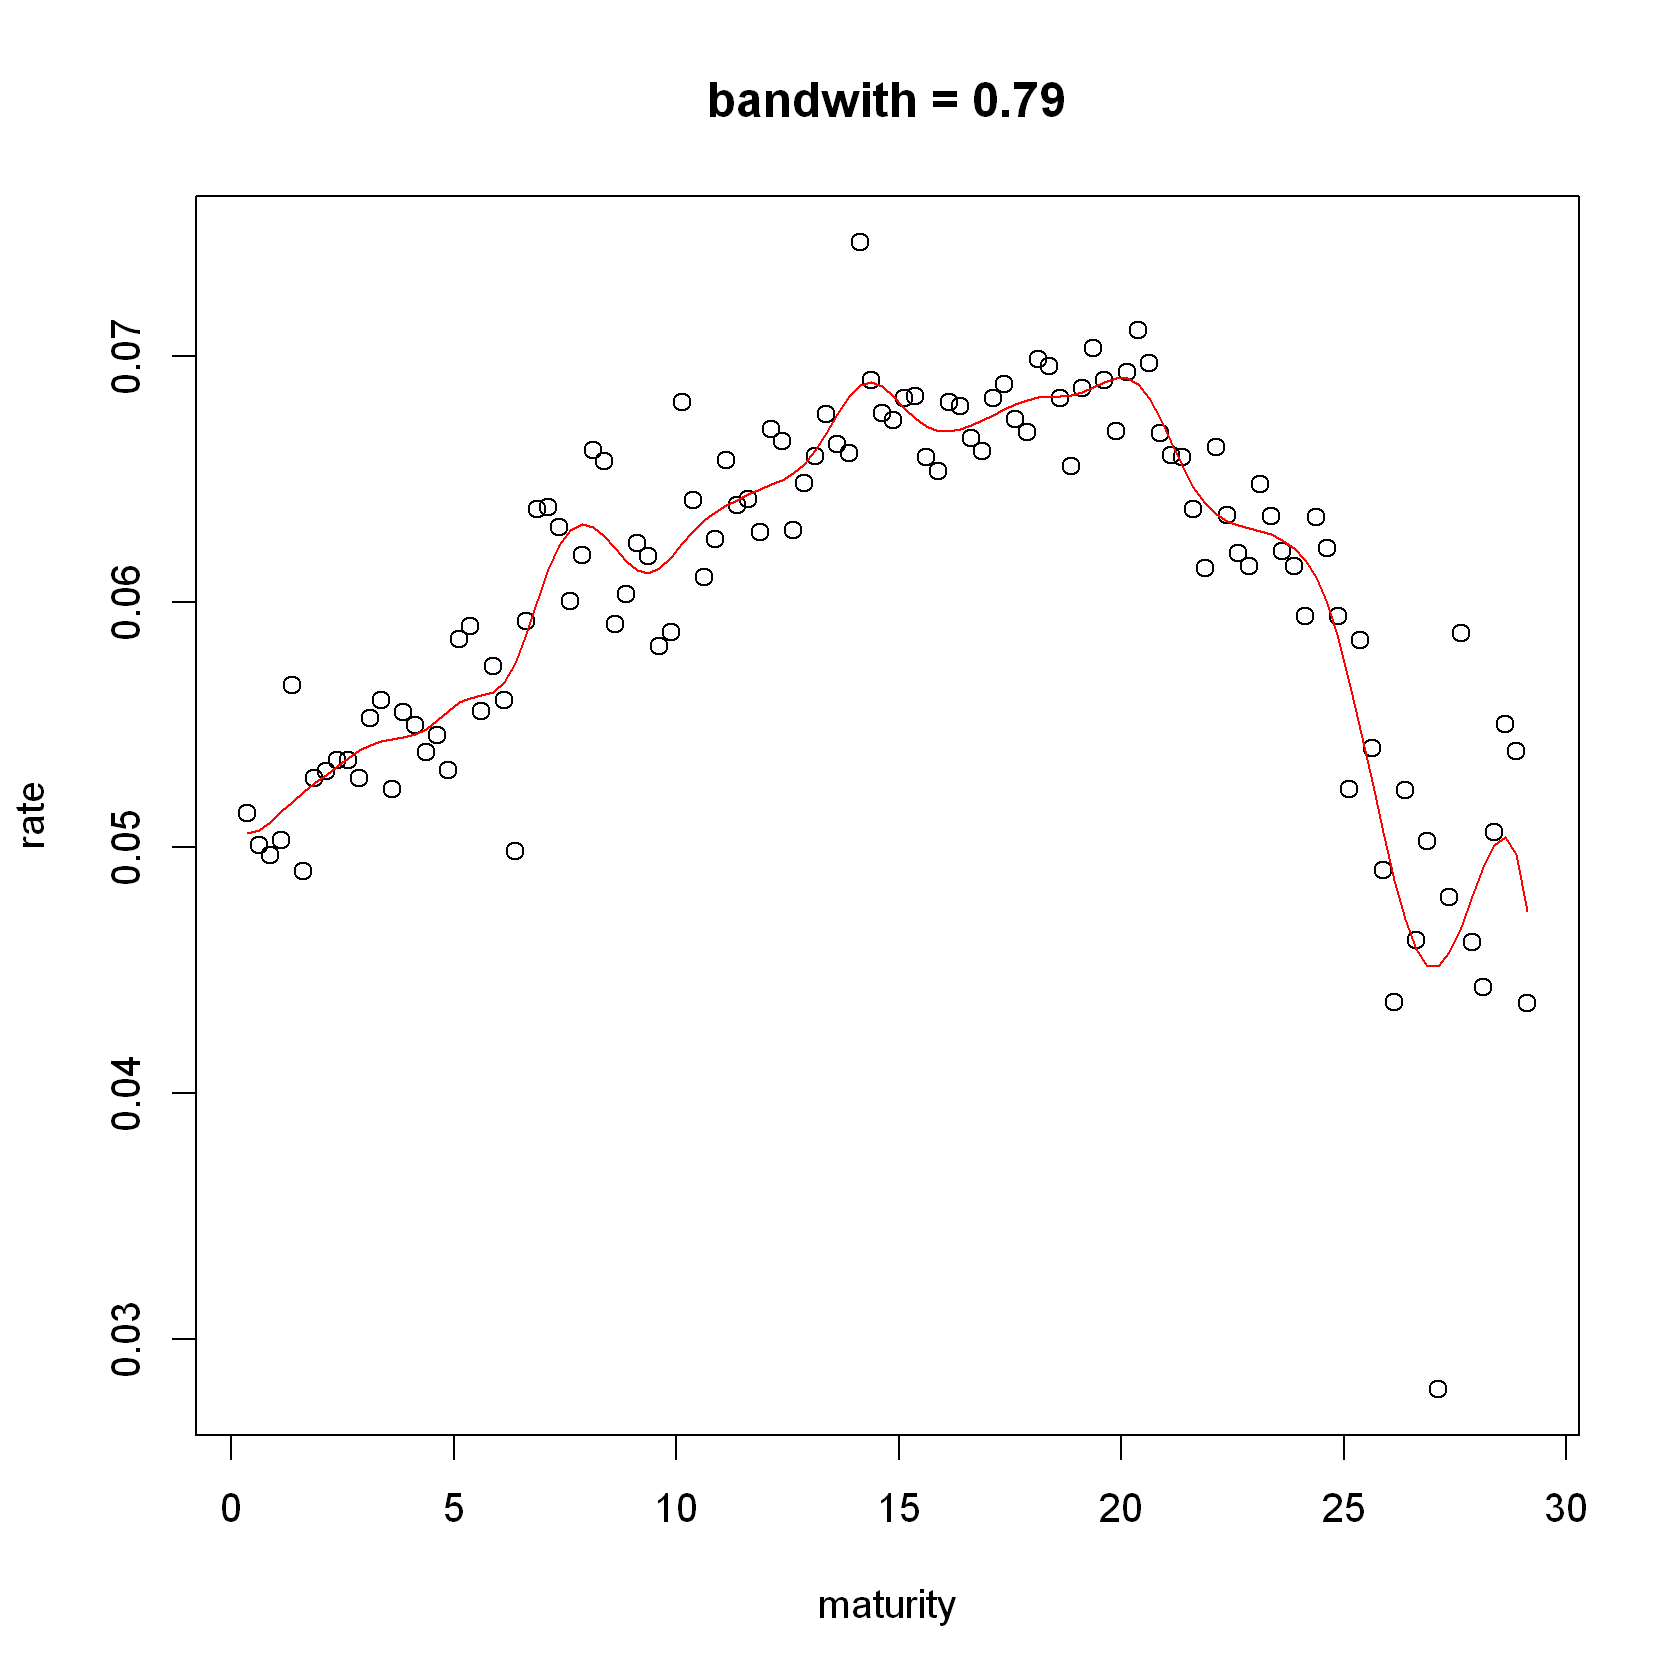

In [30]:
plot(maturity, rate, main=sprintf('bandwith = %.2f', h))
lines(maturity, mu.hat(maturity, maturity, rate, h), col='red')

##### Since the data forms a single large curve, using a large bandwith (which would use all of the data to determine polynomial) still producs a decent fit. When using the bandwith of 0.79, specified by dpill function to minimize MISE, it's intersting to see the dip around the 26 year maturity caused by an outlier with a reall low interest rate. I would like to find out more information on that specific data point as that's affecting the fit

### Part b

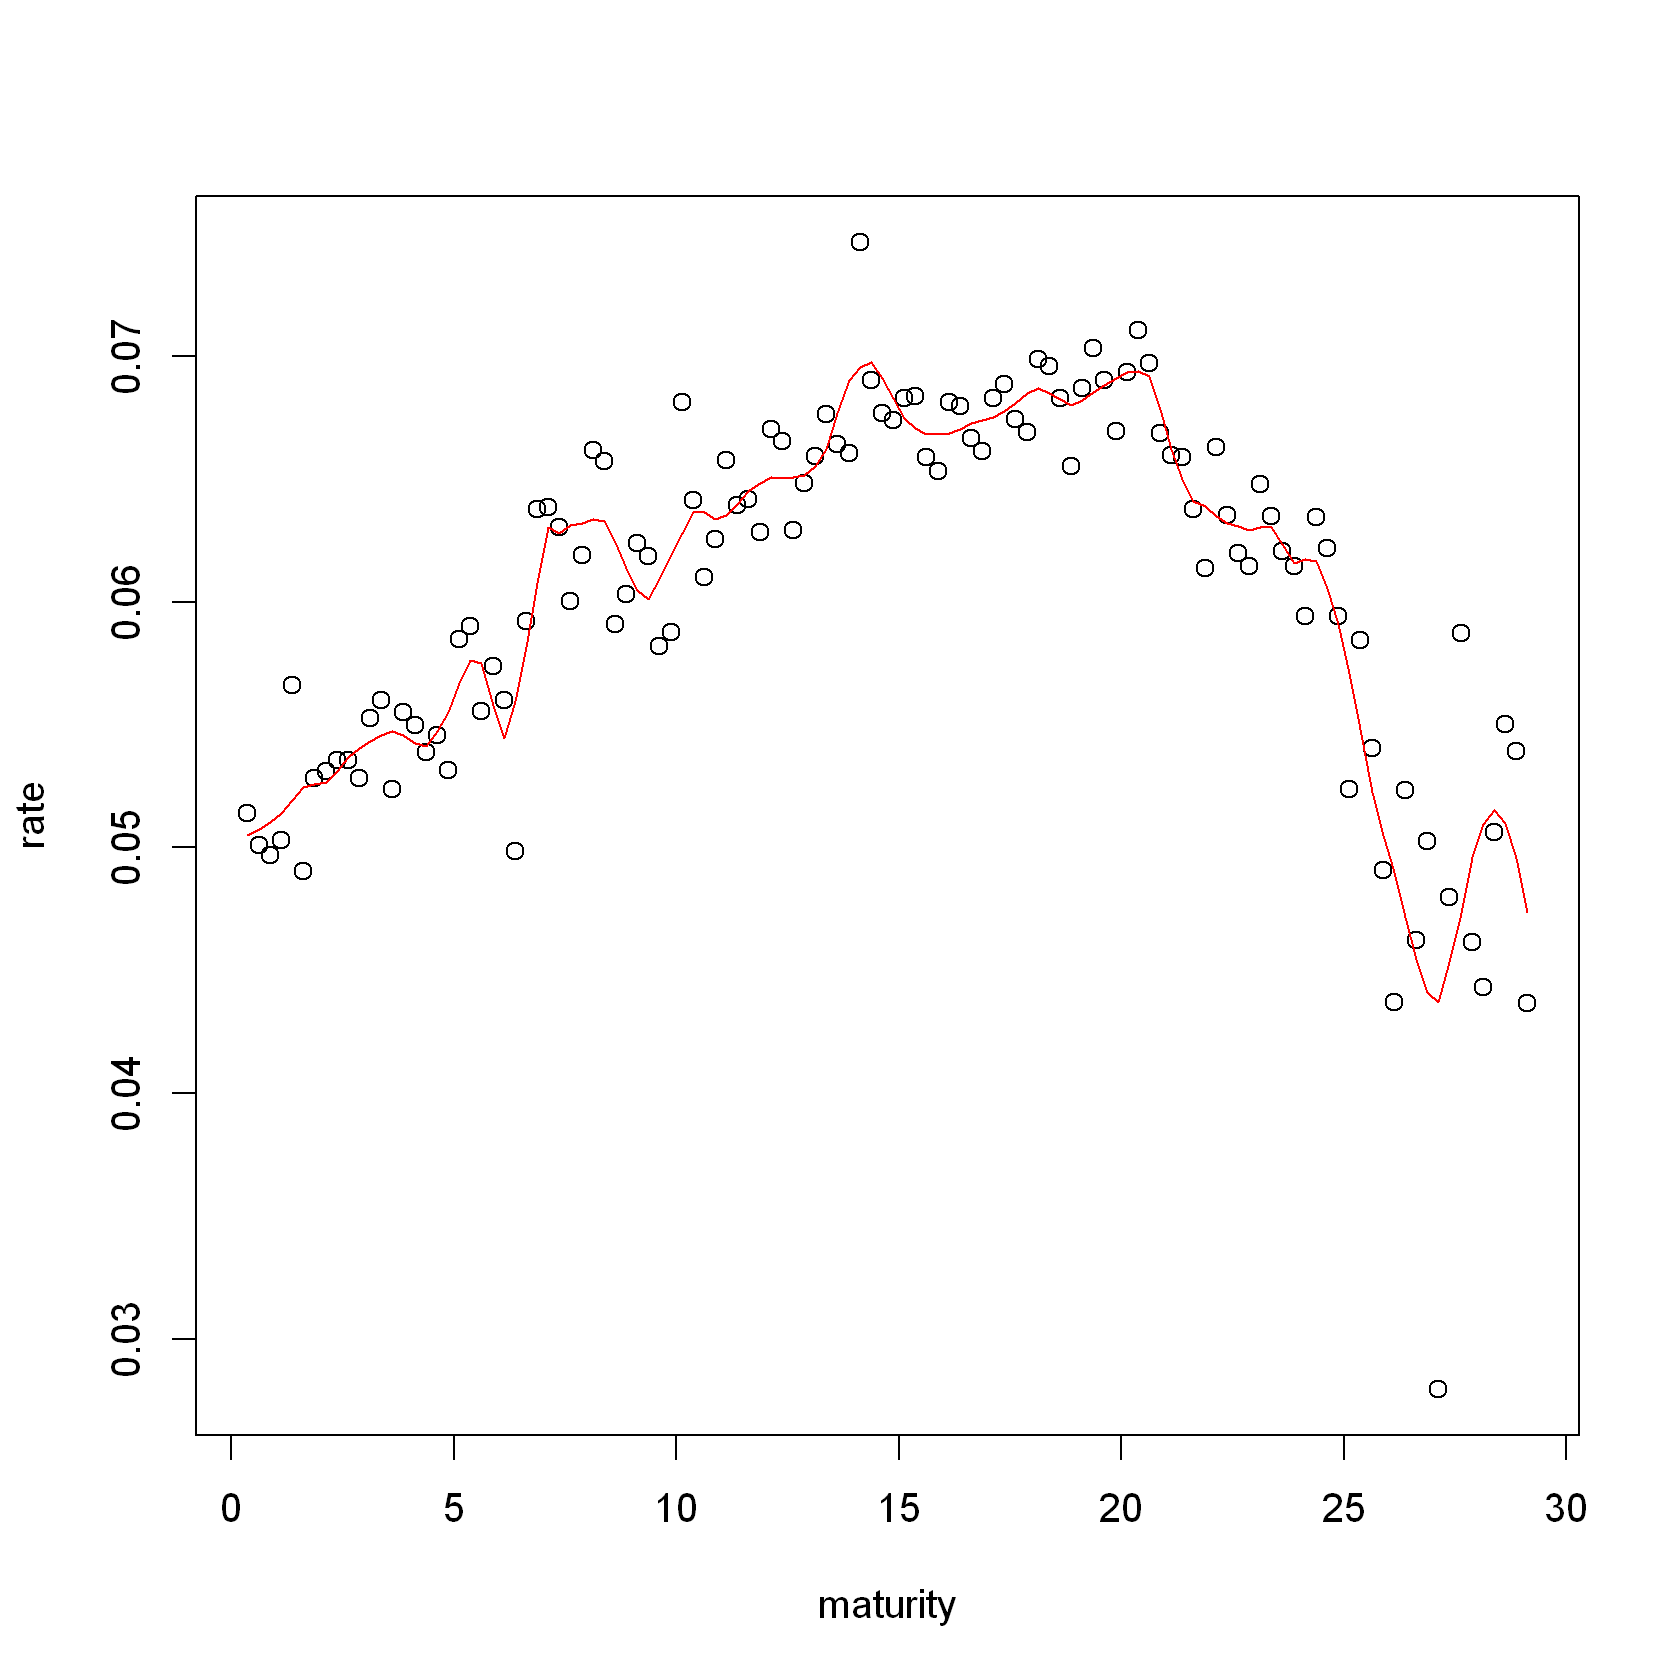

In [31]:
fit.loess <- loess(formula = rate ~ maturity, span=0.1, degree=2)
plot(maturity, rate)
lines(maturity, fit.loess$fitted, col="red")

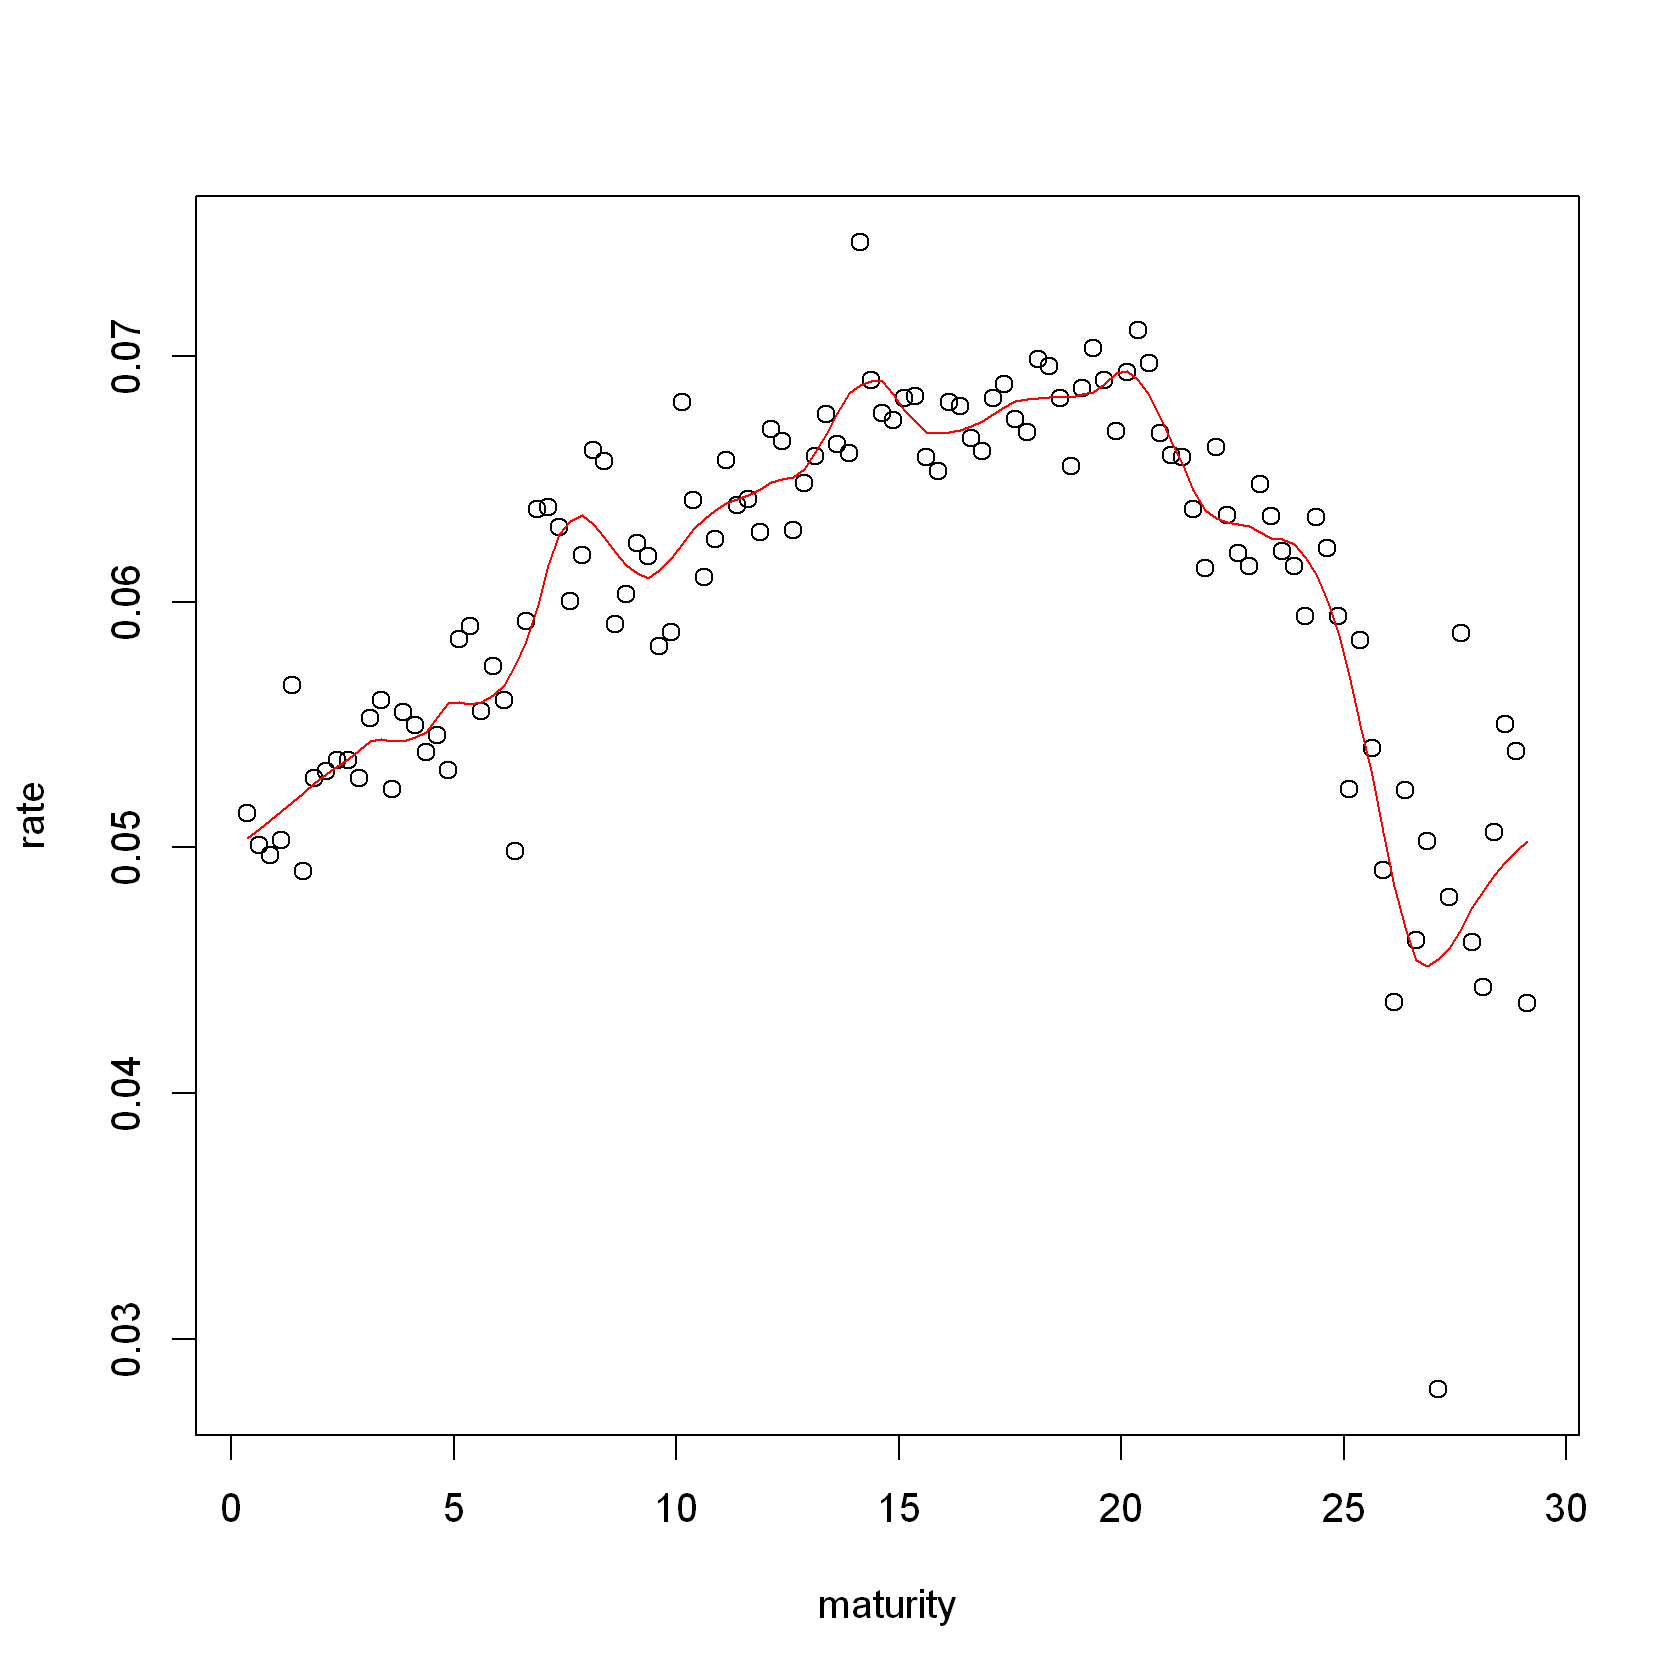

In [32]:
fit.loess <- loess(formula = rate ~ maturity, span=0.15, degree=2)
plot(maturity, rate)
lines(maturity, fit.loess$fitted, col="red")

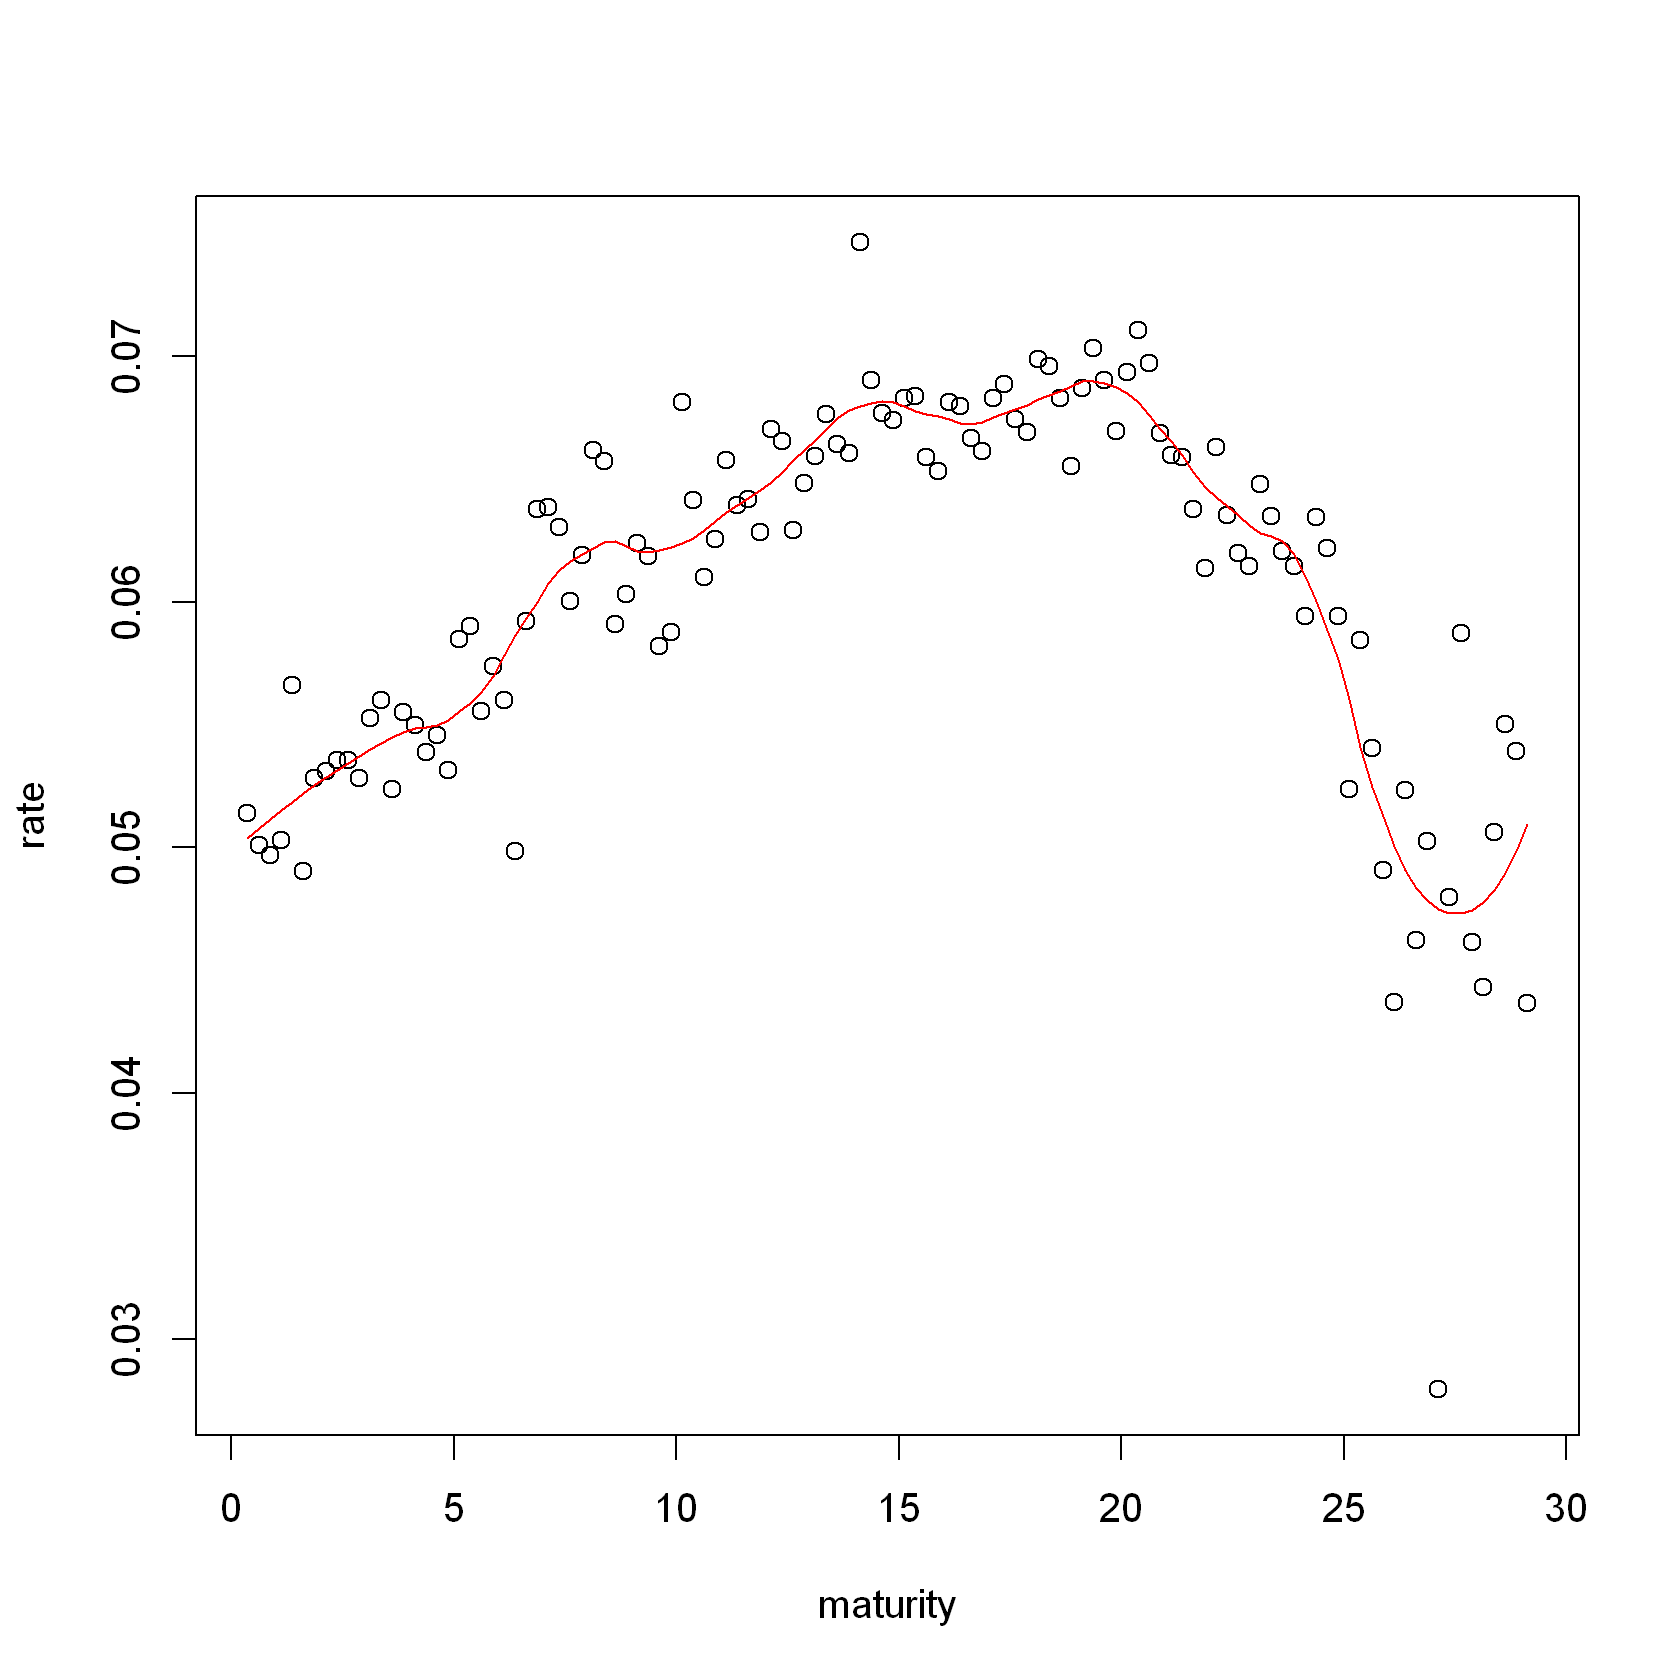

In [33]:
fit.loess <- loess(formula = rate ~ maturity, span=0.25, degree=2)
plot(maturity, rate)
lines(maturity, fit.loess$fitted, col="red")

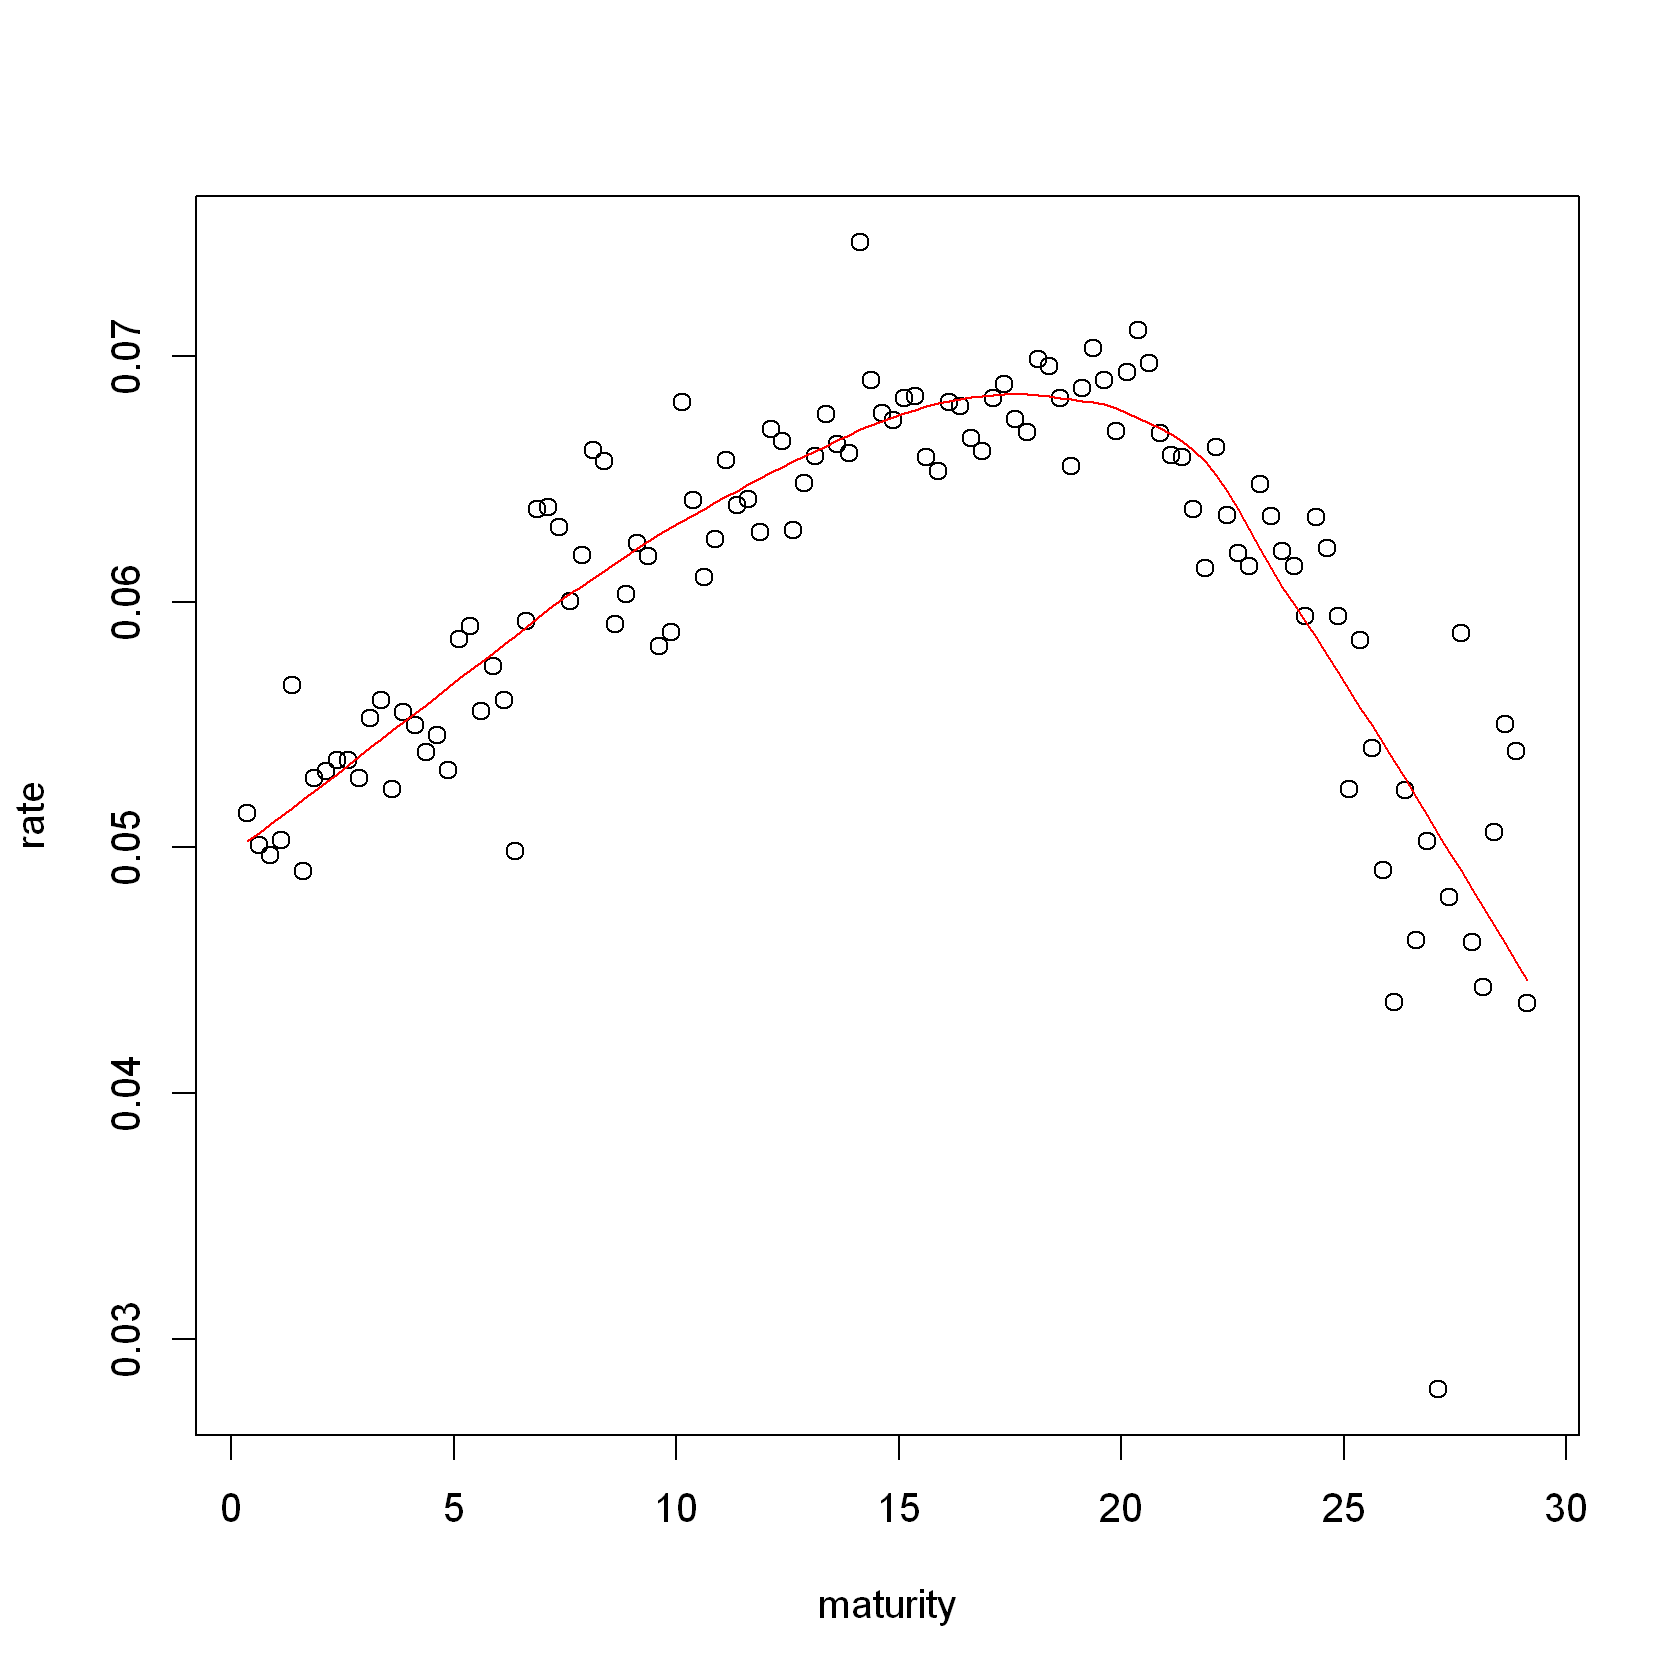

In [34]:
fit.loess <- loess(formula = rate ~ maturity, span=0.5, degree=2)
plot(maturity, rate)
lines(maturity, fit.loess$fitted, col="red")

##### The loess fits look more flat than the local poly regression. What I mean by that is it's more V shaped than parabolic. Span of 0.15 produces a fit that looks very similar to the 0.79 bandwith fit using loal poly.